# Estimate the intrinsic dimension of the Attractor of Filament Dynamics
Use this notebook to estimate the attractor dimension based on the caclulated shape mode trajectories in phase space

In [1]:
import sys
import os

if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nolds

import pyfilaments.analysisutils as analysis
from tqdm import tqdm


linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

In [2]:
batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'

# batch_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/Analysis_test'
data_folders = os.listdir(batch_data_folder)

full_path_list = []

for folder in data_folders:
    
    cwd = os.path.join(batch_data_folder, folder)
    
    files = [file for file in os.listdir(cwd) if file.endswith('.hdf5')]
    
    
    for file in files:
        
        full_path_list.append(os.path.join(cwd, file))
        

len(full_path_list)

400

In [3]:
import skdim

start_cycle = 200 # Number of cycles to ignore transients
embedding_dim = 10

df_corr_dim = pd.DataFrame({})

def estimate_attractor_dimension(full_path = None):
    
    fil = analysis.analysisTools(file = full_path)
    
    base_folder, file_name = os.path.split(full_path)

    shape_modes_file = os.path.join(fil.analysisFolder, fil.dataName[:-5]+'_ModeAmplitudes.csv')

    if os.path.exists(shape_modes_file):
        df_shape_modes = pd.read_csv(shape_modes_file)

    else:
        print('Shape modes data not found!')
        return
        
    # Neglect transients
    start_time = start_cycle*fil.activity_timescale
    start_index = next((i for i,x in enumerate(np.array(df_shape_modes['Time'])) if x>= start_time), 0)
    df_shape_modes = df_shape_modes.drop(labels = range(0,start_index))
    
    array_len = len(df_shape_modes)
    
    mode_amp_array = np.zeros((array_len,5)) # Currently we save the shape modes for the first 5 eigenvalues

    mode_amp_array[:,0] = df_shape_modes['Mode 1 amplitude']
    mode_amp_array[:,1] = df_shape_modes['Mode 2 amplitude']
    mode_amp_array[:,2] = df_shape_modes['Mode 3 amplitude']
    mode_amp_array[:,3] = df_shape_modes['Mode 4 amplitude']
    mode_amp_array[:,4] = df_shape_modes['Mode 5 amplitude']

    
    corr_dim = skdim.id.CorrInt(k1=5, k2=20).fit(mode_amp_array)
    
    # Save the correlation dimension of the attractor as a separate file
    
    analysis_file = file_name[:-5] + '_analysis.csv'
    
    df_analysis = pd.read_csv(os.path.join(base_folder, 'Analysis', analysis_file))

    
    df_analysis['Correlation dimension of attractor'] = corr_dim.dimension_
    
    print(df_analysis['potDipole strength'])
    print('estimated attractor dimension: ',corr_dim.dimension_)
    print('Filament behavior: ', df_analysis['filament behavior'][0])
    
    
    df_analysis.to_csv(os.path.join(base_folder, 'Analysis', analysis_file))
    
    
def estimate_attractor_dimension_timeseries(full_path = None):
    # Estimate the attractor dimension from a 1D time-series
    
    fil = analysis.analysisTools(file = full_path)
    base_folder, file_name = os.path.split(full_path)

    fil.compute_base_tip_angle()
    
    # Neglect trasients
    start_time = start_cycle*fil.activity_timescale
    start_index = next((i for i,x in enumerate(np.array(fil.Time)) if x>= start_time), 0)

    base_tip_array = fil.derived_data['base tip angle'][start_index:]
    time_array = fil.Time[start_index:]

    corr_dim, (rval, csums, poly) = nolds.corr_dim(base_tip_array, embedding_dim, debug_plot = False, debug_data= True)
    
    # Plot the correlation dimension estimate fit
    plt.figure()
    x_array = np.linspace(min(rval), max(rval), 50)
    fit_array = poly[0]*x_array + poly[1]
    plt.scatter(rval, csums, label = 'data')
    plt.plot(x_array, fit_array, 'k-', label = 'fit')
    plt.xlabel('log(r)')
    plt.ylabel('log(C(r))')
    plt.legend()
    plt.savefig(os.path.join(base_folder, 'Analysis', file_name[:-5]+'_CorrDim_est.png'), dpi = 150)
    plt.show()
    plt.close()

    
    # Save the correlation dimension of the attractor as a separate file
    analysis_file = file_name[:-5] + '_analysis.csv'
    df_analysis = pd.read_csv(os.path.join(base_folder, 'Analysis', analysis_file))
    df_analysis['Correlation dimension of attractor'] = corr_dim
    
    print(df_analysis['potDipole strength'])
    print('estimated attractor dimension: ',corr_dim)
    print('Filament behavior: ', df_analysis['filament behavior'][0])
    df_analysis.to_csv(os.path.join(base_folder, 'Analysis', analysis_file))

  
     
    
    

In [4]:
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()

num_cores = 2

results = Parallel(n_jobs=num_cores, verbose=10)(delayed(estimate_attractor_dimension_timeseries)(file) for file in full_path_list)


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   16.5s
exception calling callback for <Future at 0x7fb670caaeb8 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/jobl

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

  0%|          | 0/400 [00:00<?, ?it/s]

Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


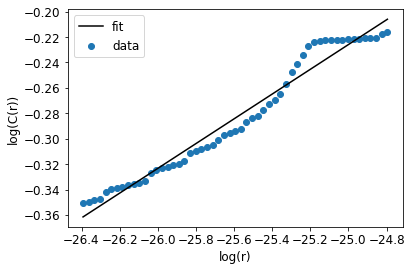

  0%|          | 1/400 [00:46<5:05:58, 46.01s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09747507706554395
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


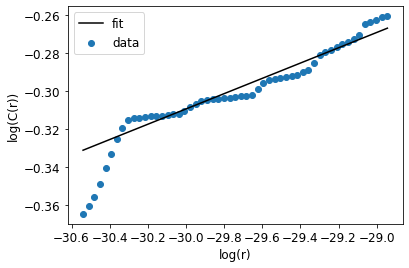

  0%|          | 2/400 [01:30<5:00:19, 45.28s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.040274866597061594
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


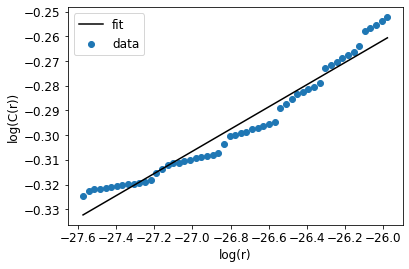

  1%|          | 3/400 [02:15<4:57:37, 44.98s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.04491137709260687
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


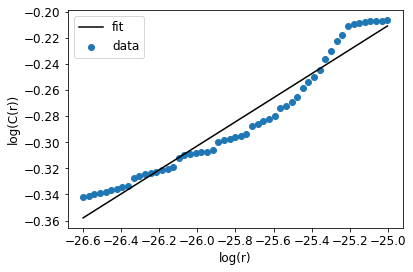

  1%|          | 4/400 [03:00<4:57:05, 45.01s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09223300794720142
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


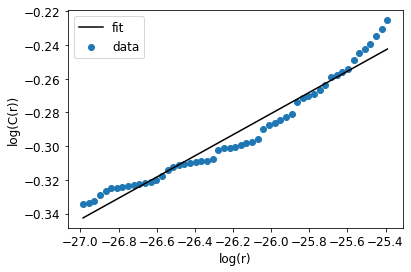

  1%|▏         | 5/400 [03:44<4:55:11, 44.84s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.06276015819741533
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


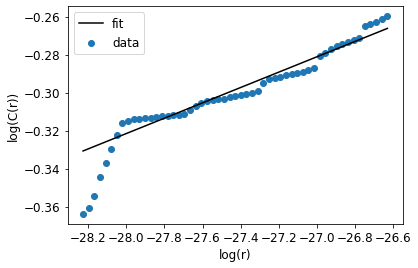

  2%|▏         | 6/400 [04:29<4:53:06, 44.64s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.04041536169354903
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


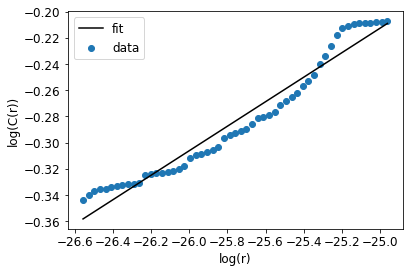

  2%|▏         | 7/400 [05:13<4:51:46, 44.55s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09344145077294452
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


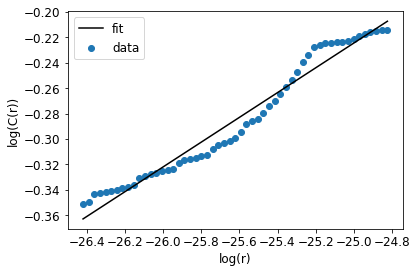

  2%|▏         | 8/400 [05:57<4:50:11, 44.42s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09729346228150663
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


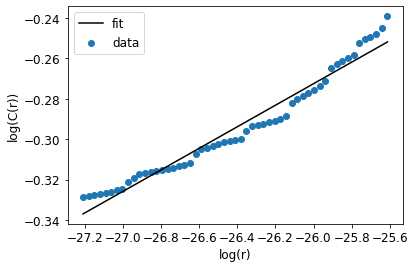

  2%|▏         | 9/400 [06:41<4:48:18, 44.24s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.05324589734598266
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00177
Activity number: 37.25723
**************************************************


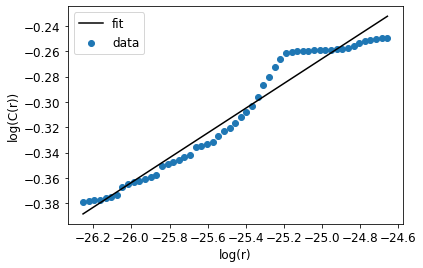

  2%|▎         | 10/400 [07:25<4:46:50, 44.13s/it]

0    0.692308
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.0977702812321698
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


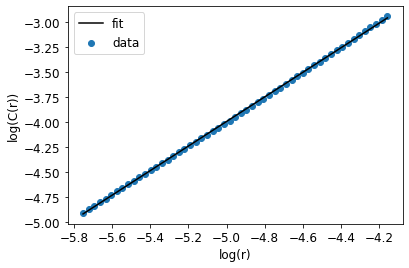

  3%|▎         | 11/400 [08:09<4:45:23, 44.02s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2270936626832585
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


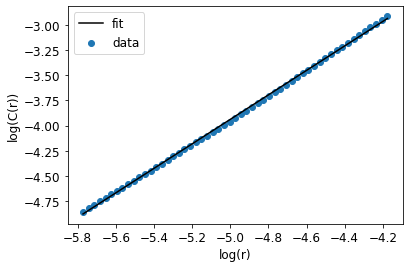

  3%|▎         | 12/400 [08:53<4:44:38, 44.02s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2153362596412132
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


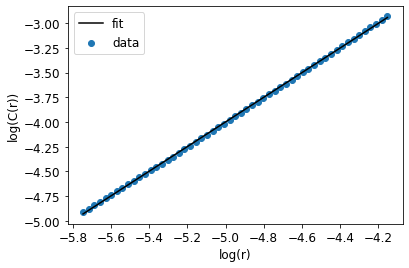

  3%|▎         | 13/400 [09:37<4:45:02, 44.19s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2455558404404803
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


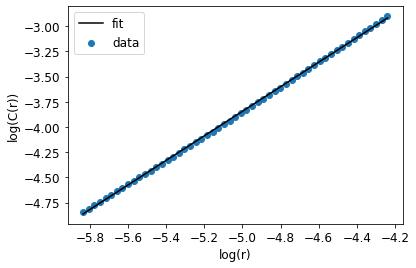

  4%|▎         | 14/400 [10:22<4:45:06, 44.32s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2180297897526167
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


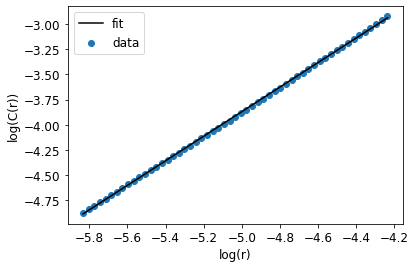

  4%|▍         | 15/400 [11:06<4:44:12, 44.29s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2176455174776684
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


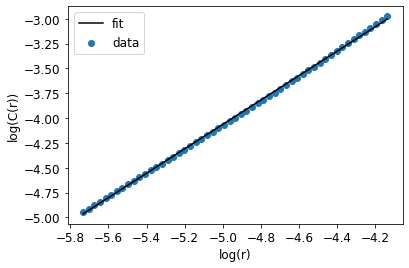

  4%|▍         | 16/400 [11:51<4:43:58, 44.37s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2290558414035069
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


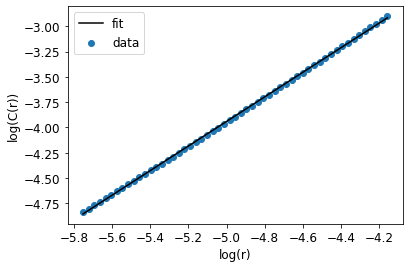

  4%|▍         | 17/400 [12:35<4:43:19, 44.39s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2151926189516276
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


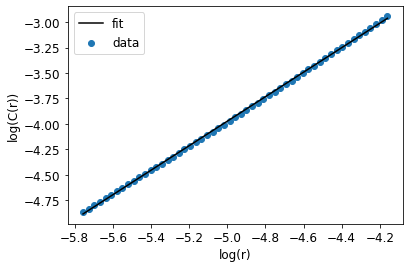

  4%|▍         | 18/400 [13:20<4:43:43, 44.56s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2061222261908968
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


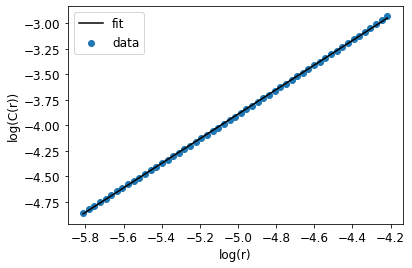

  5%|▍         | 19/400 [14:05<4:43:32, 44.65s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2012010223466218
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.93
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00276
Activity number: 57.95569
**************************************************


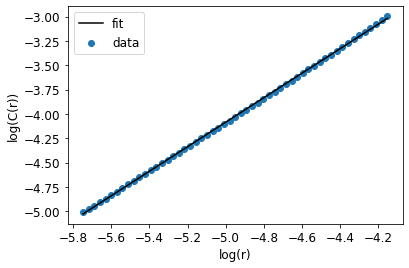

  5%|▌         | 20/400 [14:50<4:42:57, 44.68s/it]

0    1.076923
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.259699204208682
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


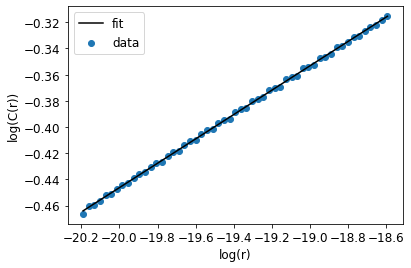

  5%|▌         | 21/400 [15:35<4:42:32, 44.73s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09309659972134884
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


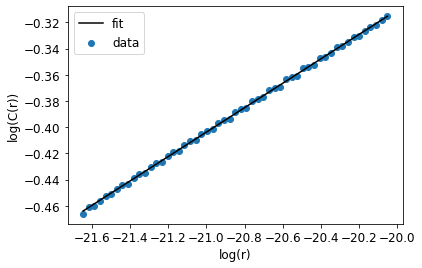

  6%|▌         | 22/400 [16:19<4:41:08, 44.62s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.0930840413488514
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


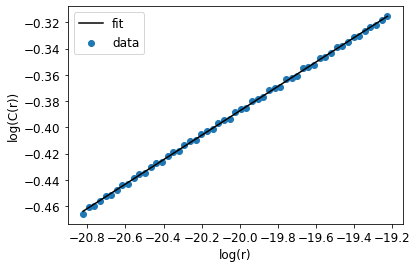

  6%|▌         | 23/400 [17:03<4:39:29, 44.48s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09307904489036567
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


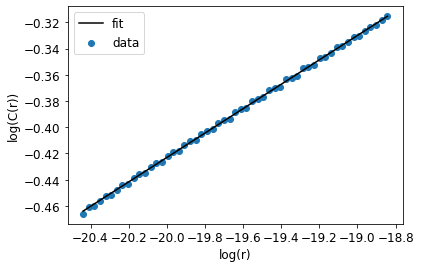

  6%|▌         | 24/400 [17:48<4:39:05, 44.53s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.0930810544869129
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


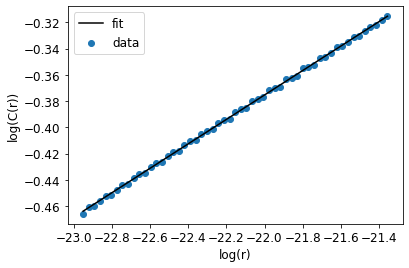

  6%|▋         | 25/400 [18:33<4:38:56, 44.63s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09307503936724555
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


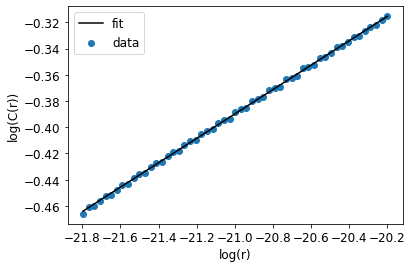

  6%|▋         | 26/400 [19:18<4:38:43, 44.71s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09307806742497472
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


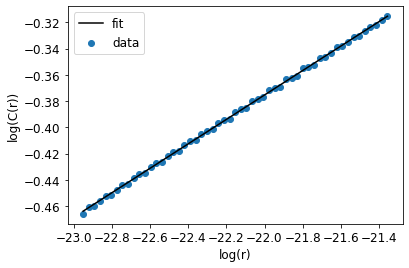

  7%|▋         | 27/400 [20:03<4:39:42, 44.99s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09307503936724555
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


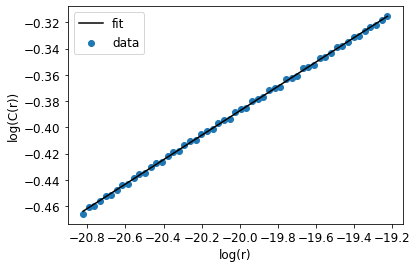

  7%|▋         | 28/400 [20:49<4:39:50, 45.14s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09307904489036567
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


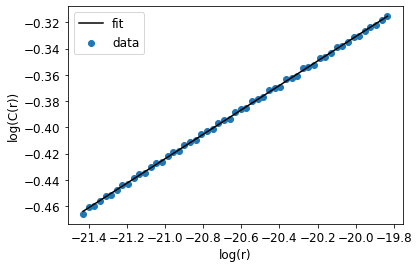

  7%|▋         | 29/400 [21:35<4:40:37, 45.38s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09307388807934468
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.77
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00144
Activity number: 30.35774
**************************************************


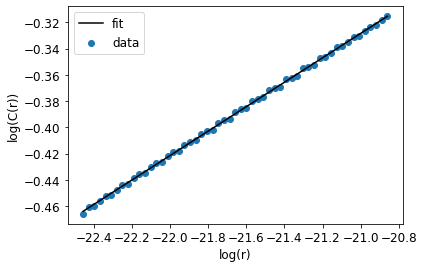

  8%|▊         | 30/400 [22:19<4:38:29, 45.16s/it]

0    0.564103
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09306993282750516
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


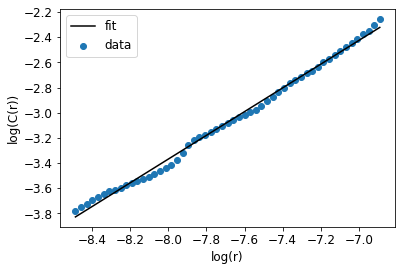

  8%|▊         | 31/400 [23:05<4:38:29, 45.28s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9435263191716587
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


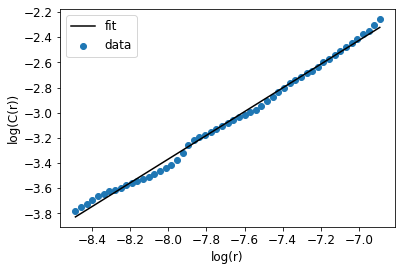

  8%|▊         | 32/400 [23:49<4:36:33, 45.09s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.943466737519541
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


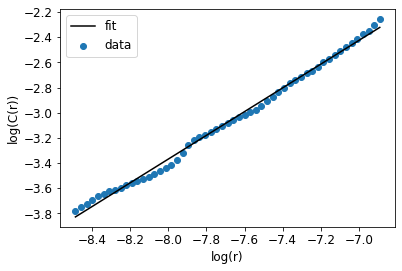

  8%|▊         | 33/400 [24:34<4:35:38, 45.07s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9434359669639362
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


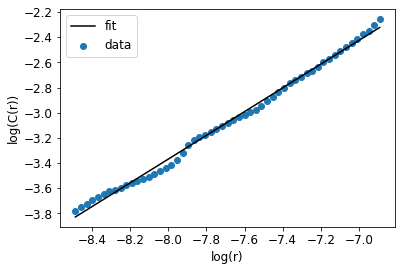

  8%|▊         | 34/400 [25:19<4:34:05, 44.93s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9435858622906648
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


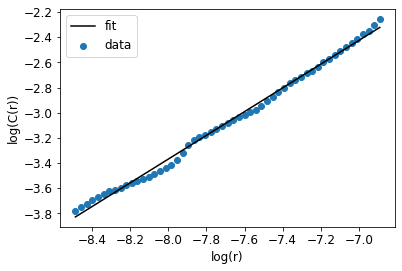

  9%|▉         | 35/400 [26:04<4:32:32, 44.80s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9435842746427597
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


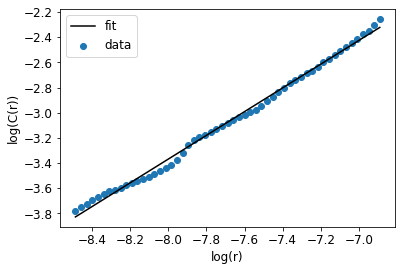

  9%|▉         | 36/400 [26:48<4:31:05, 44.68s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9435076020081279
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


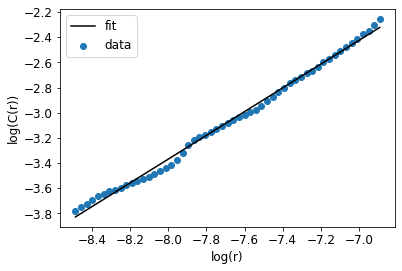

  9%|▉         | 37/400 [27:33<4:30:00, 44.63s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9435177528965805
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


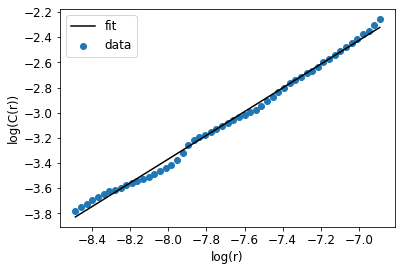

 10%|▉         | 38/400 [28:17<4:28:50, 44.56s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9434914062621443
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


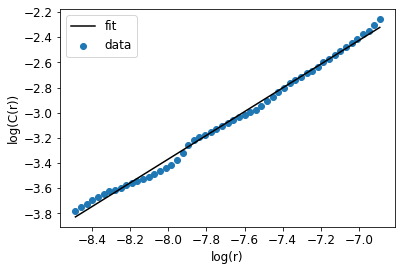

 10%|▉         | 39/400 [29:01<4:27:53, 44.53s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9435409064711283
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.05
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00243
Activity number: 51.05621
**************************************************


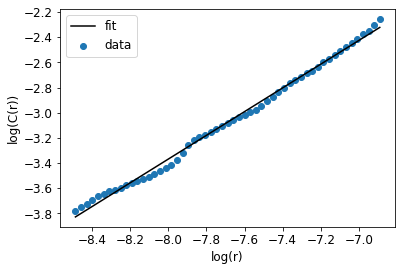

 10%|█         | 40/400 [29:46<4:26:36, 44.43s/it]

0    0.948718
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9434731104610676
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


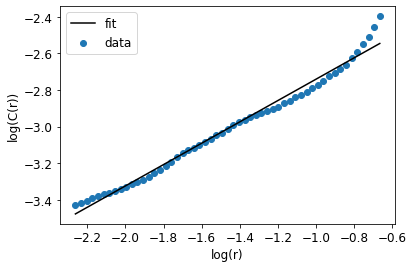

 10%|█         | 41/400 [29:46<3:06:27, 31.16s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.5837205148564635
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


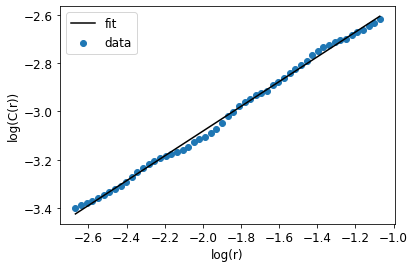

 10%|█         | 42/400 [29:46<2:10:29, 21.87s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.5130510592036779
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


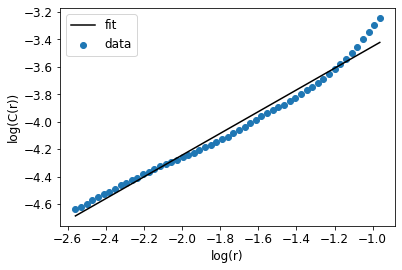

 11%|█         | 43/400 [29:46<1:31:53, 15.45s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.79218220857649
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


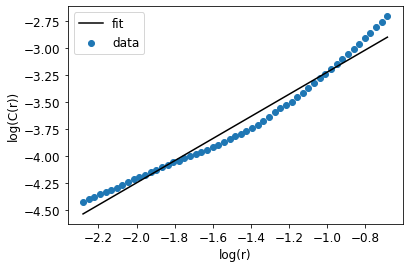

 11%|█         | 44/400 [29:47<1:04:43, 10.91s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0217057671390277
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


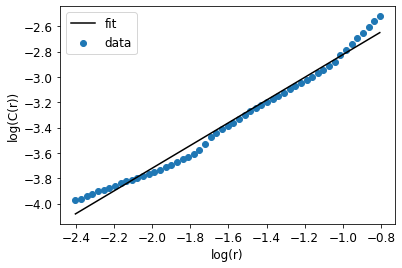

 11%|█▏        | 45/400 [29:47<45:34,  7.70s/it]  

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8967017649043549
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


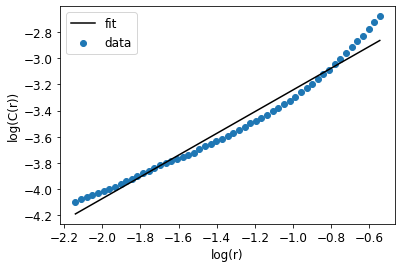

 12%|█▏        | 46/400 [29:47<32:16,  5.47s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8301716020883128
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


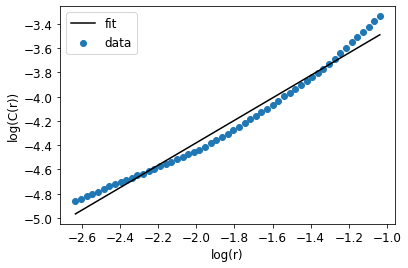

 12%|█▏        | 47/400 [29:48<23:34,  4.01s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9251846087078915
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


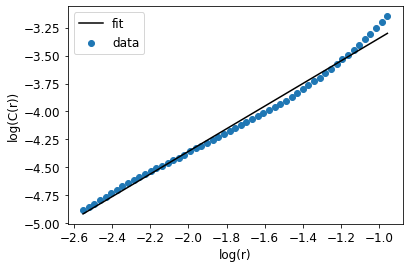

 12%|█▏        | 48/400 [29:49<18:13,  3.11s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0118647863930907
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


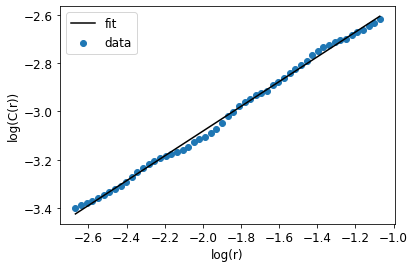

 12%|█▏        | 49/400 [29:49<13:02,  2.23s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.5130510592036779
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.34
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00752
Activity number: 157.99826
**************************************************


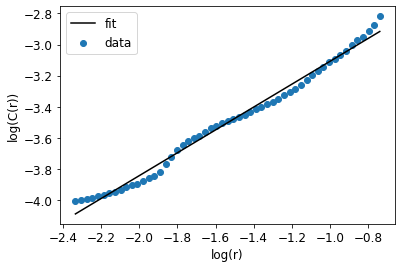

 12%|█▎        | 50/400 [29:49<09:31,  1.63s/it]

0    2.935897
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.7348817315772036
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


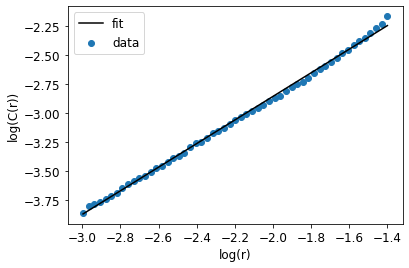

 13%|█▎        | 51/400 [30:33<1:23:28, 14.35s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208417334193143
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


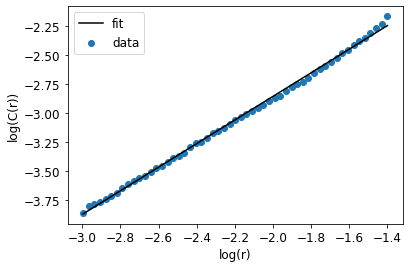

 13%|█▎        | 52/400 [31:17<2:15:13, 23.31s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.020856332354698
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


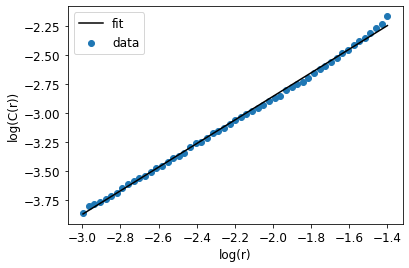

 13%|█▎        | 53/400 [32:02<2:51:17, 29.62s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208285978019387
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


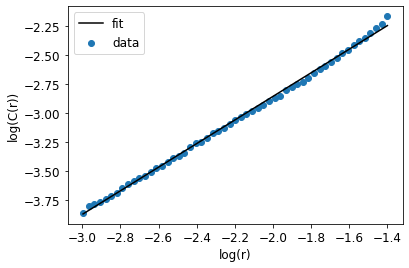

 14%|█▎        | 54/400 [32:46<3:16:17, 34.04s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208135609914621
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


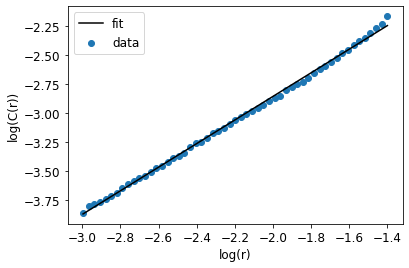

 14%|█▍        | 55/400 [33:31<3:33:29, 37.13s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208083908389287
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


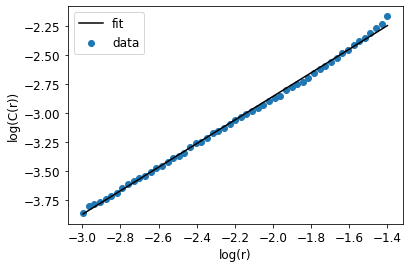

 14%|█▍        | 56/400 [34:15<3:45:03, 39.26s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208231145517004
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


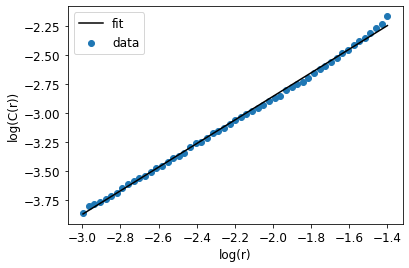

 14%|█▍        | 57/400 [34:59<3:53:17, 40.81s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208285978019387
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


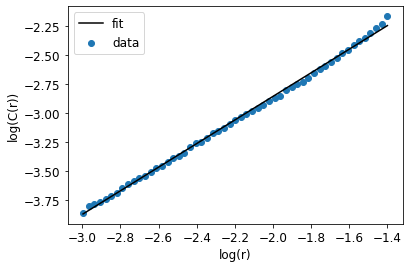

 14%|█▍        | 58/400 [35:43<3:58:36, 41.86s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208263279038408
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


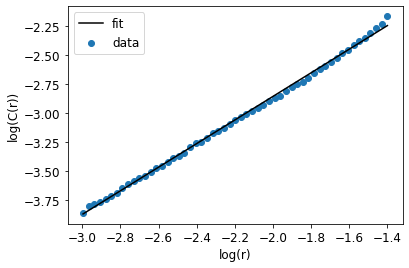

 15%|█▍        | 59/400 [36:28<4:01:40, 42.52s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208561203287707
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.51
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00505
Activity number: 106.2521
**************************************************


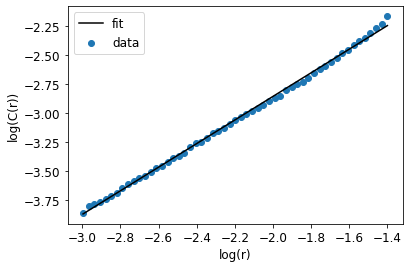

 15%|█▌        | 60/400 [37:13<4:05:10, 43.27s/it]

0    1.974359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0208038025291364
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


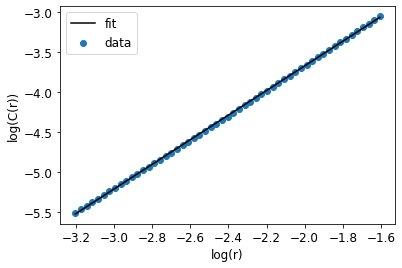

 15%|█▌        | 61/400 [37:56<4:05:37, 43.47s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5372312206723249
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


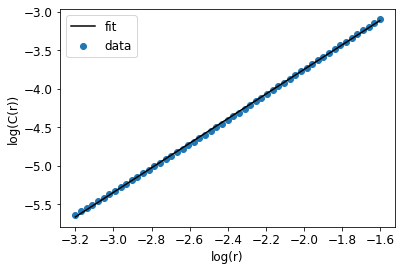

 16%|█▌        | 62/400 [38:40<4:05:41, 43.61s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5965474719160793
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


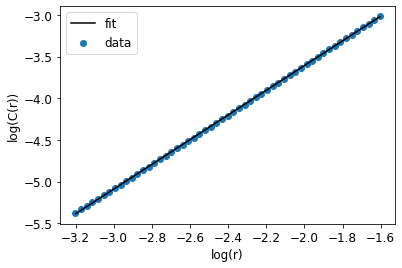

 16%|█▌        | 63/400 [39:25<4:05:51, 43.77s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.480528064403705
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


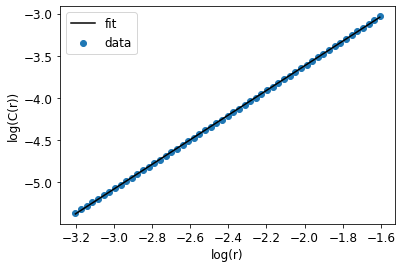

 16%|█▌        | 64/400 [40:08<4:04:45, 43.71s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.463753158893824
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


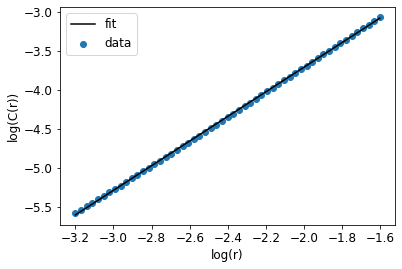

 16%|█▋        | 65/400 [40:52<4:04:10, 43.73s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.578350846557046
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


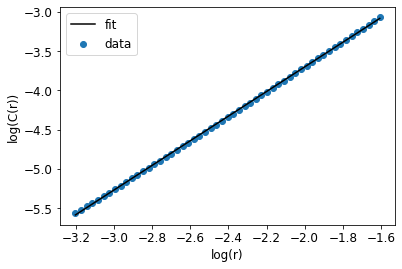

 16%|█▋        | 66/400 [41:36<4:04:04, 43.85s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.565433921408812
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


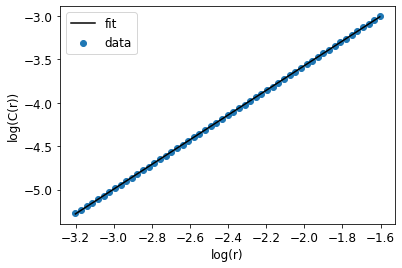

 17%|█▋        | 67/400 [42:20<4:03:53, 43.94s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4231429251062673
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


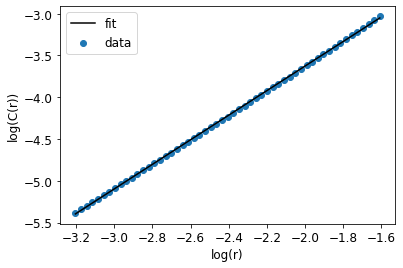

 17%|█▋        | 68/400 [43:04<4:03:27, 44.00s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4690440921850425
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


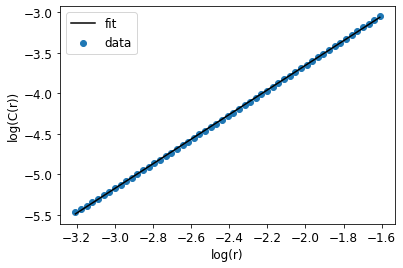

 17%|█▋        | 69/400 [43:48<4:02:50, 44.02s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5210143807402479
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.68
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00374
Activity number: 78.65415
**************************************************


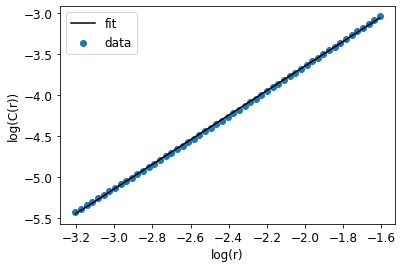

 18%|█▊        | 70/400 [44:33<4:02:18, 44.06s/it]

0    1.461538
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4985492271921053
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


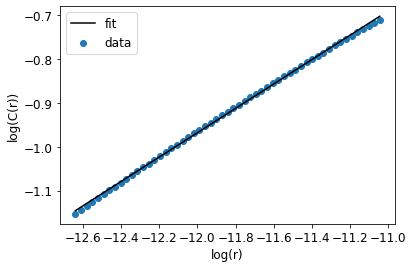

 18%|█▊        | 71/400 [45:16<4:01:19, 44.01s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.27745533681698925
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


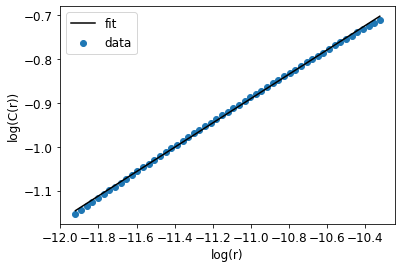

 18%|█▊        | 72/400 [46:00<4:00:13, 43.94s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.27744138381514144
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


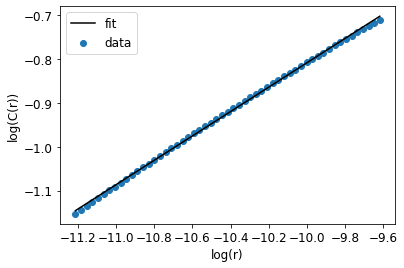

 18%|█▊        | 73/400 [46:44<3:59:11, 43.89s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.2774384394313488
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


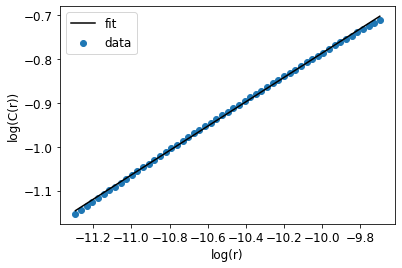

 18%|█▊        | 74/400 [47:29<3:59:36, 44.10s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.2774451577525048
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


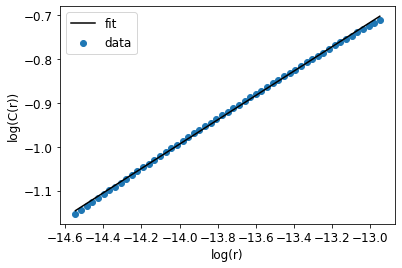

 19%|█▉        | 75/400 [48:13<3:59:04, 44.14s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.27744688234030107
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


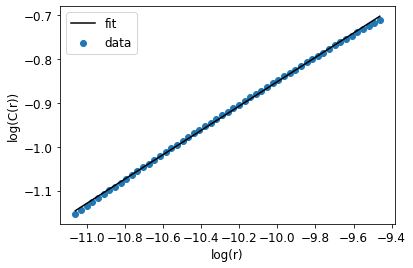

 19%|█▉        | 76/400 [48:57<3:58:50, 44.23s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.2774502789381688
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


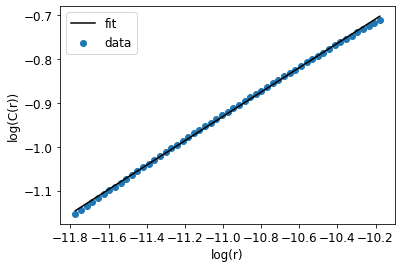

 19%|█▉        | 77/400 [49:42<3:58:22, 44.28s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.27745291631994173
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


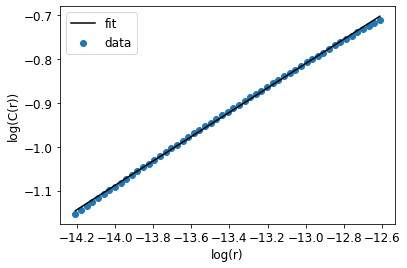

 20%|█▉        | 78/400 [50:27<3:58:48, 44.50s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.2774470949503795
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


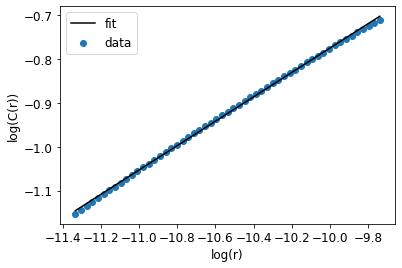

 20%|█▉        | 79/400 [51:11<3:57:23, 44.37s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.2774458427401735
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 2.0
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00128
Activity number: 26.908
**************************************************


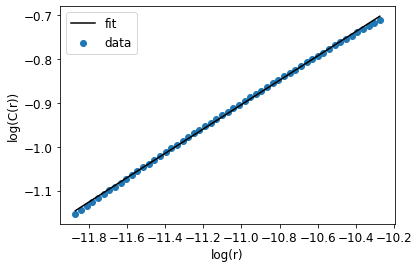

 20%|██        | 80/400 [51:55<3:57:00, 44.44s/it]

0    0.5
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.2774508304278583
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


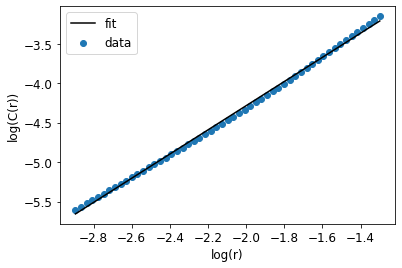

 20%|██        | 81/400 [52:40<3:56:51, 44.55s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5315898792317437
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


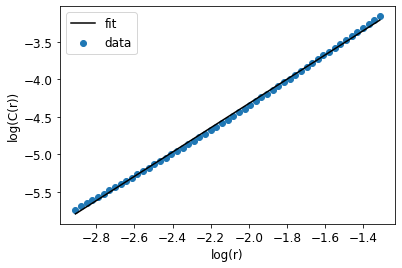

 20%|██        | 82/400 [53:24<3:55:27, 44.43s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6183094982979636
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


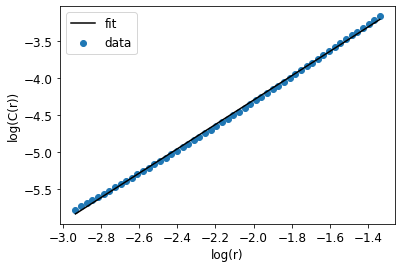

 21%|██        | 83/400 [54:09<3:54:29, 44.38s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6432086804288062
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


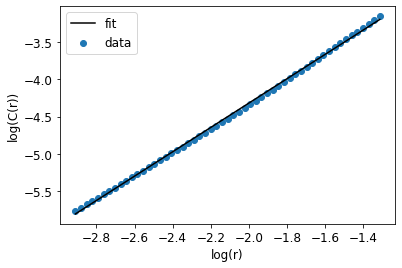

 21%|██        | 84/400 [54:53<3:53:10, 44.27s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6293548709968384
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


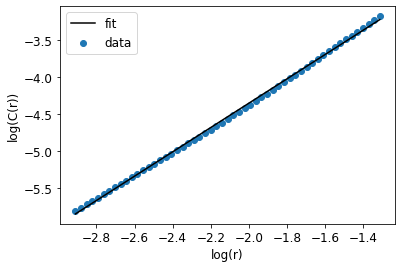

 21%|██▏       | 85/400 [55:37<3:52:10, 44.22s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6452352038138631
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


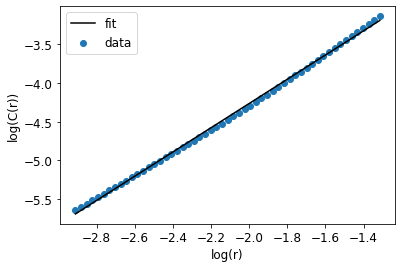

 22%|██▏       | 86/400 [56:21<3:51:16, 44.19s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5671585277707378
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


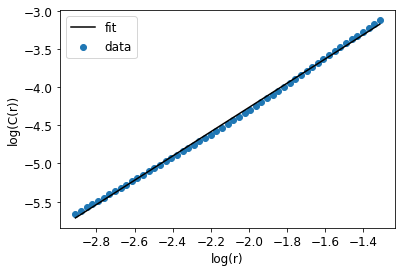

 22%|██▏       | 87/400 [57:05<3:50:37, 44.21s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5942643228917508
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


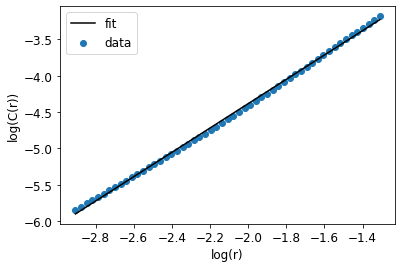

 22%|██▏       | 88/400 [57:49<3:49:33, 44.15s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6717946689043663
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


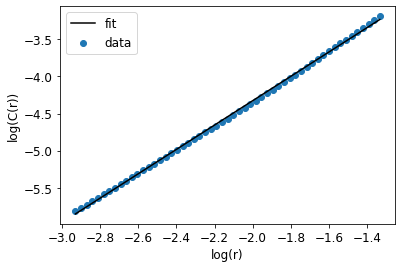

 22%|██▏       | 89/400 [58:33<3:48:35, 44.10s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6422040695161138
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.58
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0044
Activity number: 92.45313
**************************************************


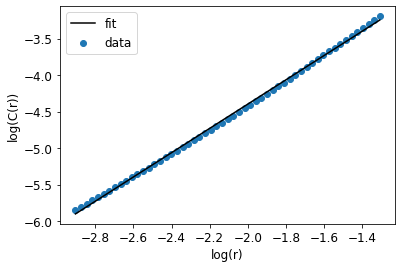

 22%|██▎       | 90/400 [59:17<3:47:44, 44.08s/it]

0    1.717949
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6632938456070179
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


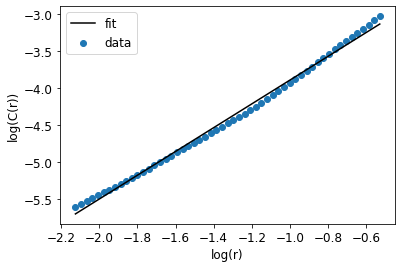

 23%|██▎       | 91/400 [59:24<2:49:50, 32.98s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6042689411504134
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


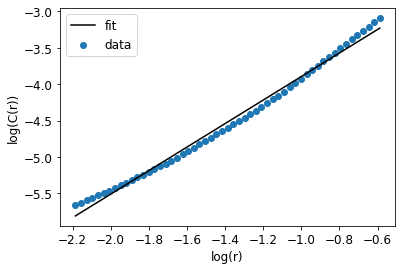

 23%|██▎       | 92/400 [59:27<2:02:42, 23.90s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.618928869119838
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


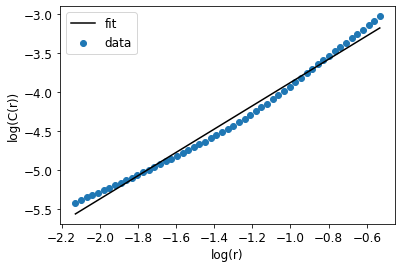

 23%|██▎       | 93/400 [59:30<1:30:31, 17.69s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4936009694328778
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


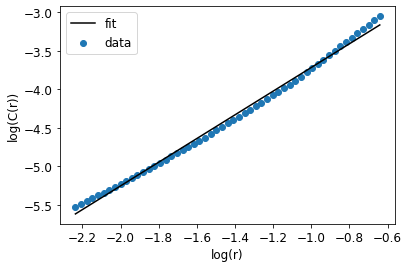

 24%|██▎       | 94/400 [59:32<1:06:20, 13.01s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5378955341716742
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


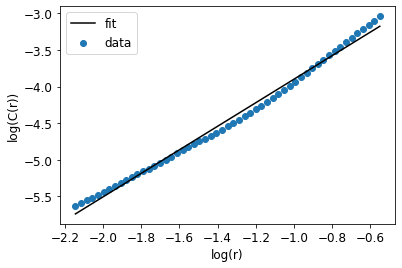

 24%|██▍       | 95/400 [59:40<57:52, 11.39s/it]  

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6048340598441824
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


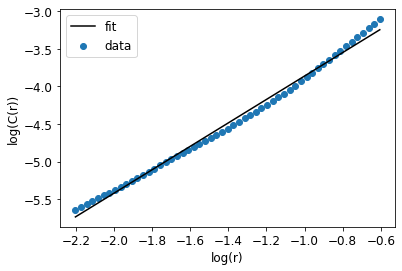

 24%|██▍       | 96/400 [59:54<1:01:44, 12.18s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5608080744078816
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


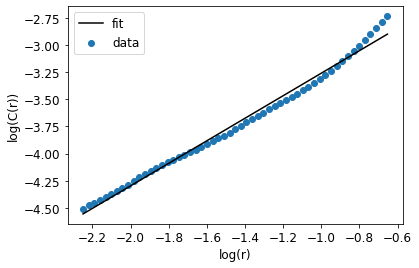

 24%|██▍       | 97/400 [59:54<43:32,  8.62s/it]  

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0369781406865828
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


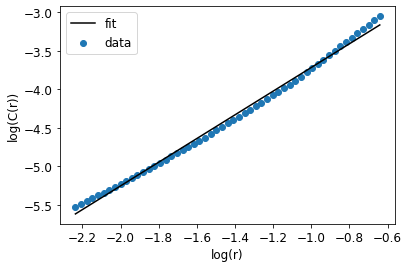

 24%|██▍       | 98/400 [59:56<33:30,  6.66s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5378955341716742
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


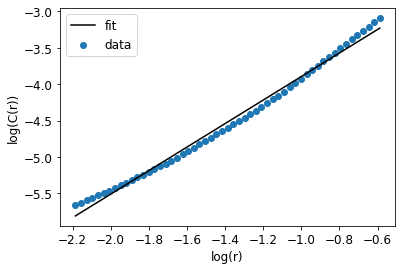

 25%|██▍       | 99/400 [59:59<27:30,  5.48s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.618928869119838
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.37
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00686
Activity number: 144.19928
**************************************************


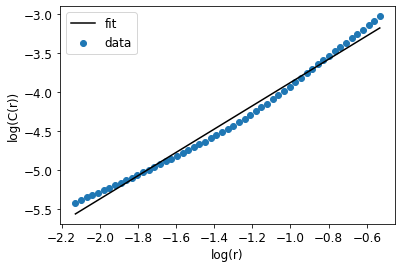

 25%|██▌       | 100/400 [1:00:02<23:57,  4.79s/it]

0    2.679487
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4936009694328778
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


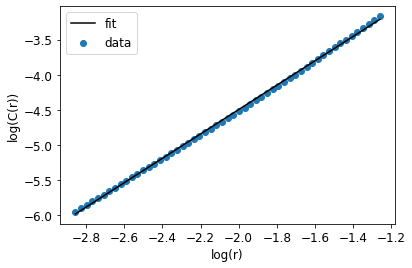

 25%|██▌       | 101/400 [1:00:46<1:22:45, 16.61s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7326086562500722
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


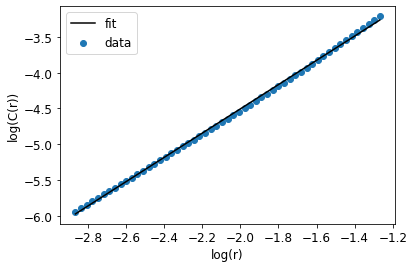

 26%|██▌       | 102/400 [1:01:30<2:03:33, 24.88s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6965485799448397
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


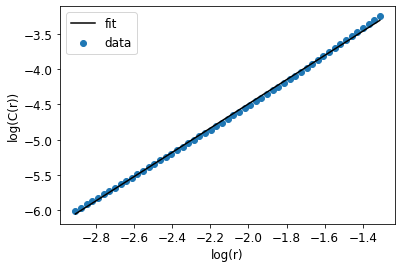

 26%|██▌       | 103/400 [1:02:15<2:31:42, 30.65s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7165377453138737
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


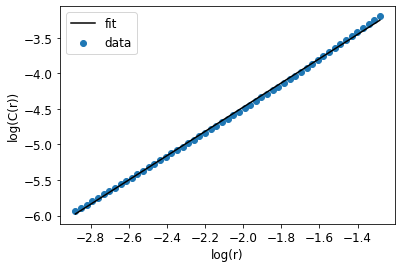

 26%|██▌       | 104/400 [1:02:59<2:50:56, 34.65s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7056699254280214
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


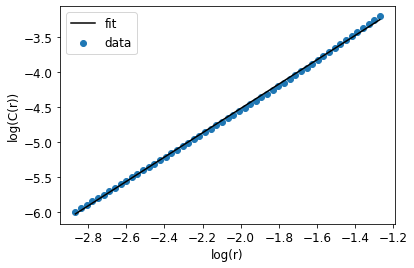

 26%|██▋       | 105/400 [1:03:43<3:04:03, 37.44s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7391708980300975
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


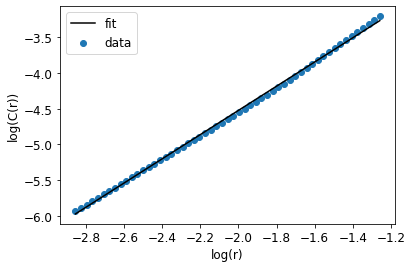

 26%|██▋       | 106/400 [1:04:27<3:13:26, 39.48s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6902717159870277
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


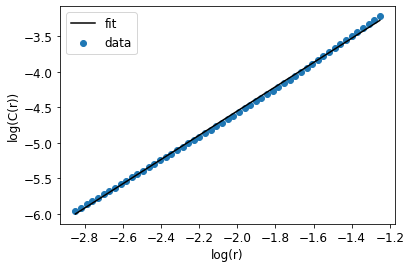

 27%|██▋       | 107/400 [1:05:11<3:19:47, 40.91s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7050888356626266
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


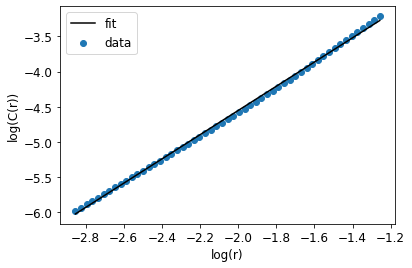

 27%|██▋       | 108/400 [1:05:55<3:23:37, 41.84s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7239169117439697
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


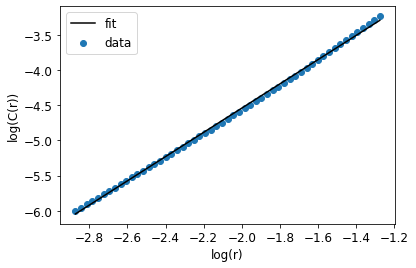

 27%|██▋       | 109/400 [1:06:39<3:26:23, 42.56s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7207515705262102
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.56
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00456
Activity number: 95.90287
**************************************************


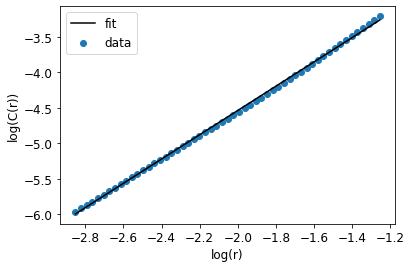

 28%|██▊       | 110/400 [1:07:23<3:28:01, 43.04s/it]

0    1.782051
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7145472202369612
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


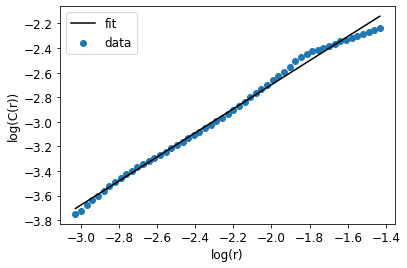

 28%|██▊       | 111/400 [1:08:08<3:29:07, 43.42s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9798323639330776
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


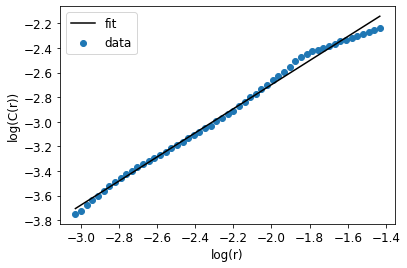

 28%|██▊       | 112/400 [1:08:52<3:29:41, 43.69s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9799905096849381
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


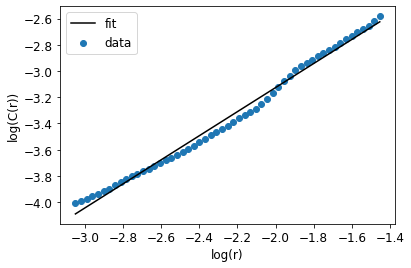

 28%|██▊       | 113/400 [1:09:37<3:30:06, 43.93s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9173448965447448
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


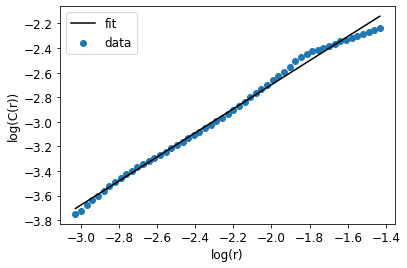

 28%|██▊       | 114/400 [1:10:21<3:30:25, 44.15s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9798323639330776
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


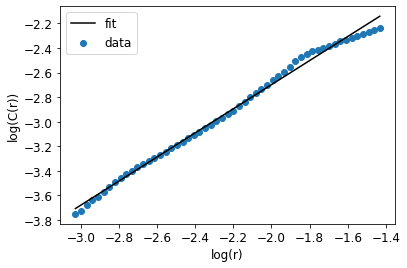

 29%|██▉       | 115/400 [1:11:05<3:29:35, 44.12s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9803035577528944
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


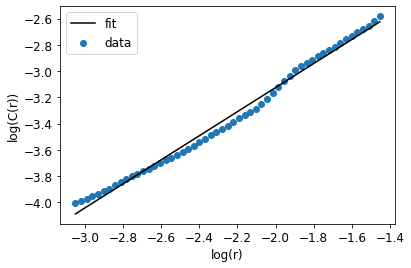

 29%|██▉       | 116/400 [1:11:49<3:28:41, 44.09s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9171975715406206
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


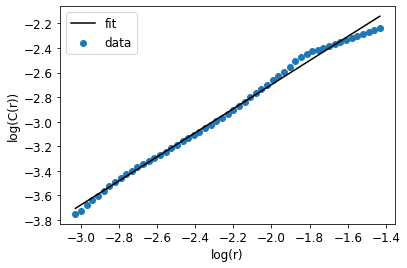

 29%|██▉       | 117/400 [1:12:33<3:28:04, 44.12s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9801260572973616
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


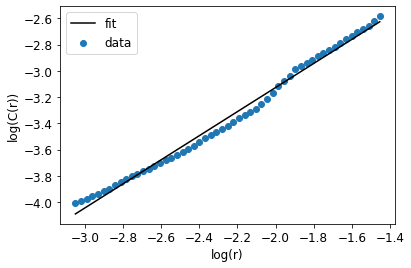

 30%|██▉       | 118/400 [1:13:18<3:27:18, 44.11s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9182668367428855
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


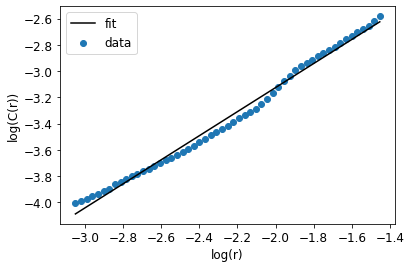

 30%|██▉       | 119/400 [1:14:02<3:26:44, 44.15s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9172517814432385
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.63
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00407
Activity number: 85.55364
**************************************************


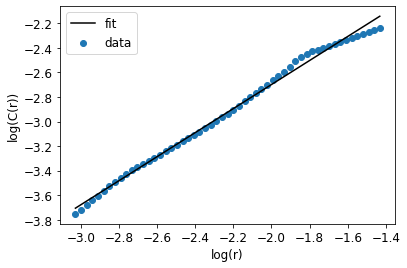

 30%|███       | 120/400 [1:14:46<3:26:07, 44.17s/it]

0    1.589744
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9794620744564407
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


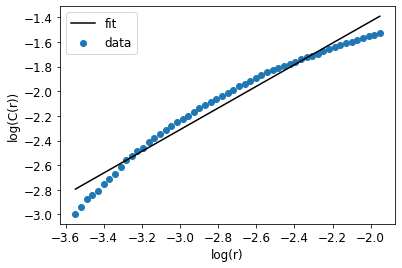

 30%|███       | 121/400 [1:15:30<3:25:24, 44.17s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8789585398636942
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


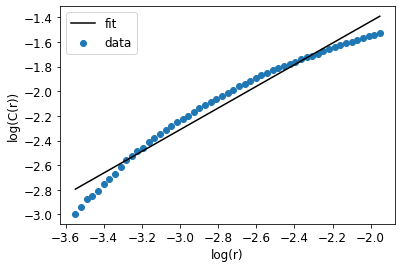

 30%|███       | 122/400 [1:16:14<3:24:50, 44.21s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8789794120249649
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


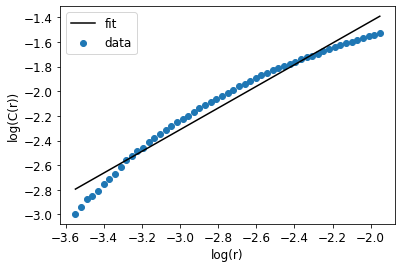

 31%|███       | 123/400 [1:16:59<3:24:25, 44.28s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8789897247161395
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


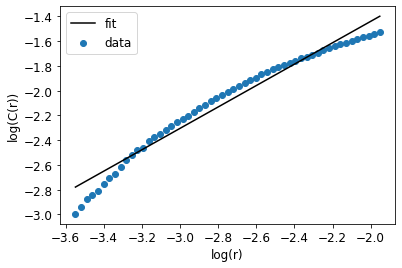

 31%|███       | 124/400 [1:17:43<3:23:54, 44.33s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8646944780714295
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


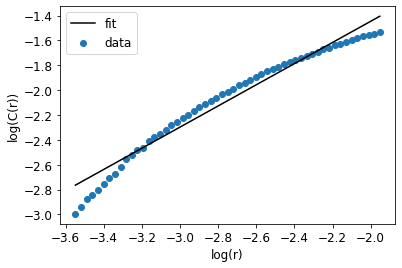

 31%|███▏      | 125/400 [1:18:28<3:23:18, 44.36s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8510935311616262
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


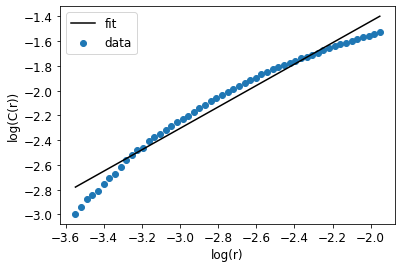

 32%|███▏      | 126/400 [1:19:12<3:22:42, 44.39s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8647088454253842
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


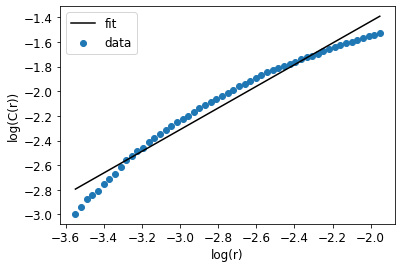

 32%|███▏      | 127/400 [1:19:57<3:21:52, 44.37s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8789716967316663
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


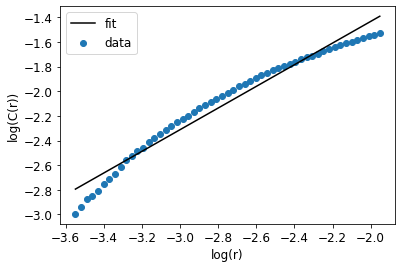

 32%|███▏      | 128/400 [1:20:41<3:20:59, 44.34s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8789808647506498
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


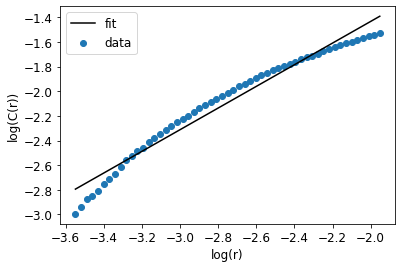

 32%|███▏      | 129/400 [1:21:25<3:19:58, 44.27s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8789710734907069
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.79
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00325
Activity number: 68.30492
**************************************************


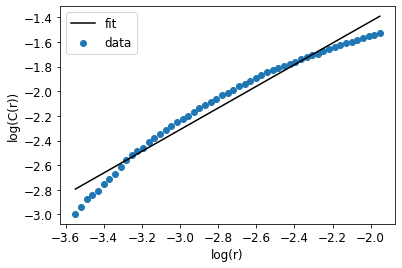

 32%|███▎      | 130/400 [1:22:10<3:20:06, 44.47s/it]

0    1.269231
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8789324787635157
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


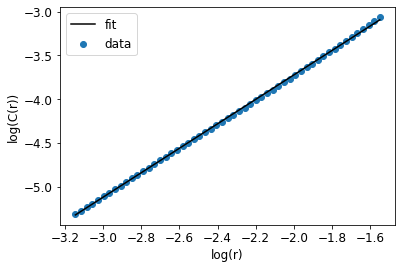

 33%|███▎      | 131/400 [1:22:54<3:18:43, 44.33s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3968909220913652
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


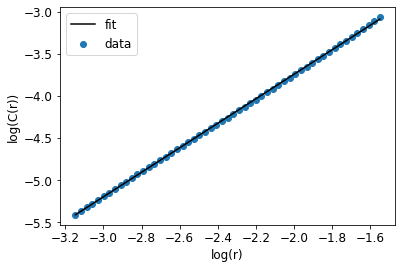

 33%|███▎      | 132/400 [1:23:38<3:17:44, 44.27s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4565815684332901
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


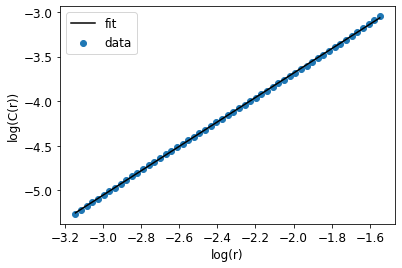

 33%|███▎      | 133/400 [1:24:22<3:16:40, 44.20s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3688317436928066
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


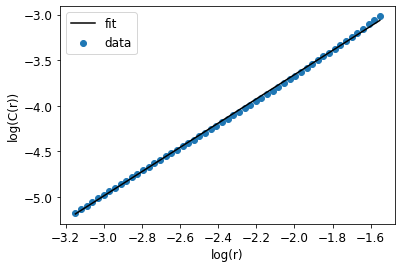

 34%|███▎      | 134/400 [1:25:06<3:16:05, 44.23s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3299057264258811
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


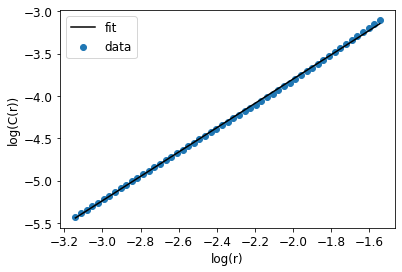

 34%|███▍      | 135/400 [1:25:51<3:15:17, 44.22s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4380217656928276
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


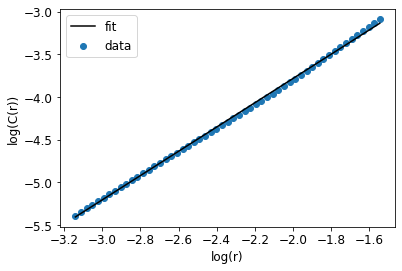

 34%|███▍      | 136/400 [1:26:35<3:14:29, 44.20s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4206416009444405
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


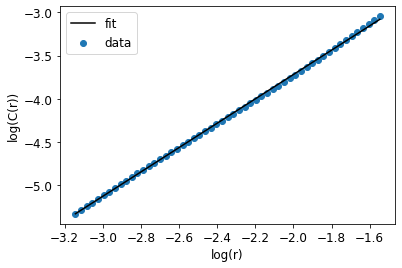

 34%|███▍      | 137/400 [1:27:19<3:13:51, 44.23s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4079922346325466
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


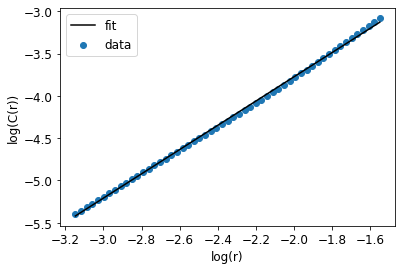

 34%|███▍      | 138/400 [1:28:03<3:12:49, 44.16s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4350052865500065
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


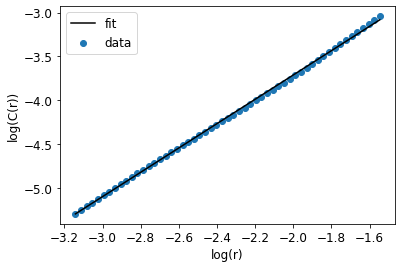

 35%|███▍      | 139/400 [1:28:47<3:11:53, 44.11s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3847508191439402
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.66
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00391
Activity number: 82.1039
**************************************************


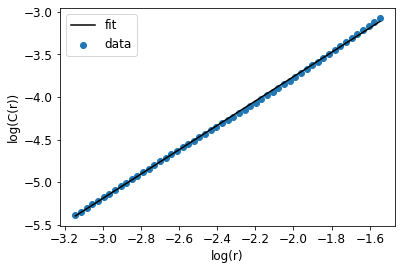

 35%|███▌      | 140/400 [1:29:31<3:11:24, 44.17s/it]

0    1.525641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4299935488336684
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


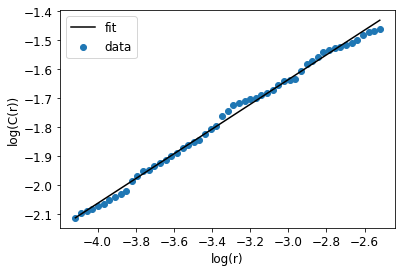

 35%|███▌      | 141/400 [1:30:16<3:10:57, 44.24s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42721188059738546
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


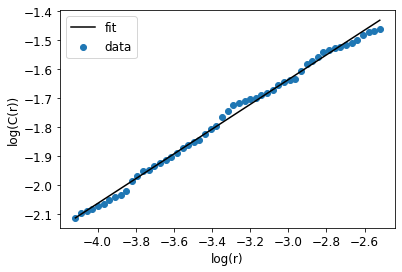

 36%|███▌      | 142/400 [1:31:00<3:10:27, 44.29s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42718314109698974
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


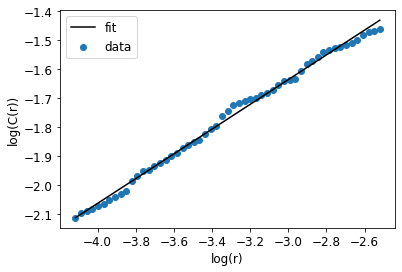

 36%|███▌      | 143/400 [1:31:45<3:09:56, 44.34s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42719841799205277
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


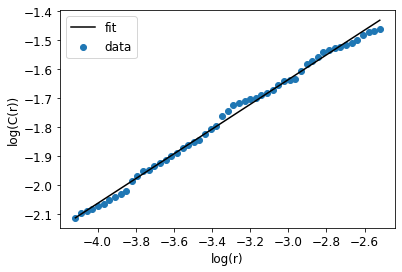

 36%|███▌      | 144/400 [1:32:29<3:09:49, 44.49s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42719414150273494
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


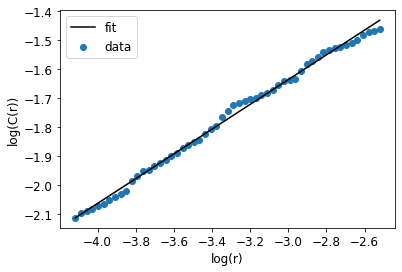

 36%|███▋      | 145/400 [1:33:14<3:08:45, 44.41s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42720832535560505
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


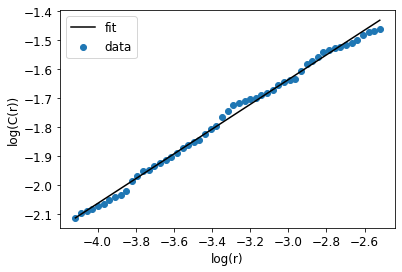

 36%|███▋      | 146/400 [1:33:58<3:07:55, 44.39s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42718314109698974
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


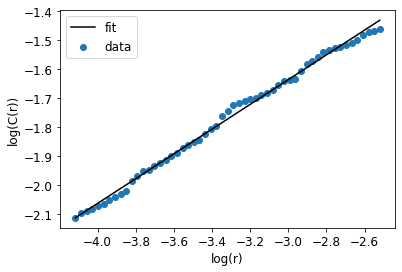

 37%|███▋      | 147/400 [1:34:43<3:07:53, 44.56s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4271921303792304
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


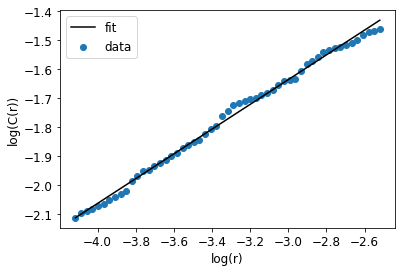

 37%|███▋      | 148/400 [1:35:27<3:06:59, 44.52s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42720391188508733
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


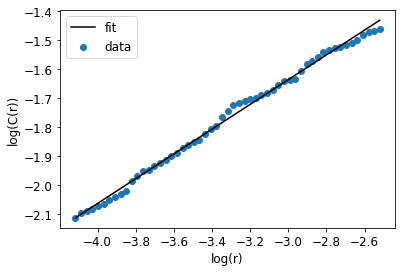

 37%|███▋      | 149/400 [1:36:12<3:06:09, 44.50s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42719345622892474
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.4
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00637
Activity number: 133.85005
**************************************************


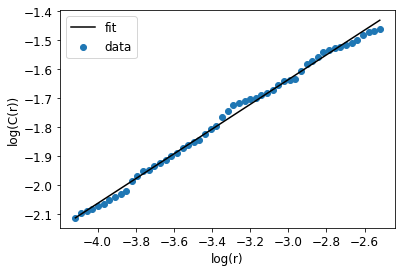

 38%|███▊      | 150/400 [1:36:56<3:05:18, 44.47s/it]

0    2.487179
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4271930251497468
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


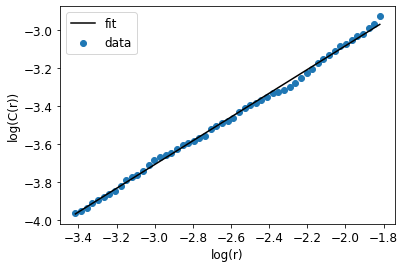

 38%|███▊      | 151/400 [1:37:40<3:04:13, 44.39s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6266574973035834
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


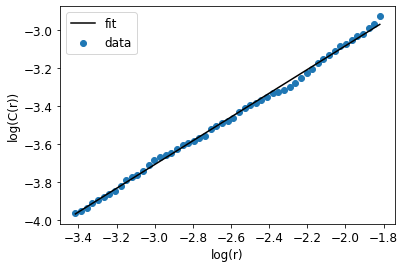

 38%|███▊      | 152/400 [1:38:24<3:03:01, 44.28s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6266574973035834
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


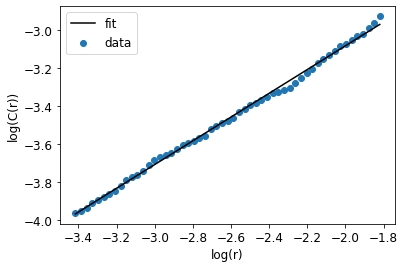

 38%|███▊      | 153/400 [1:39:09<3:02:18, 44.29s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.62639677803208
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


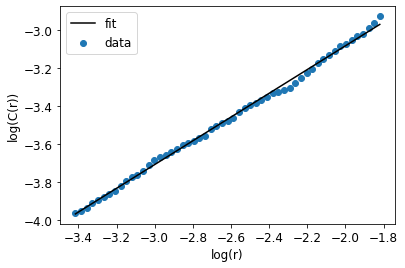

 38%|███▊      | 154/400 [1:39:53<3:01:36, 44.29s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6267728379424744
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


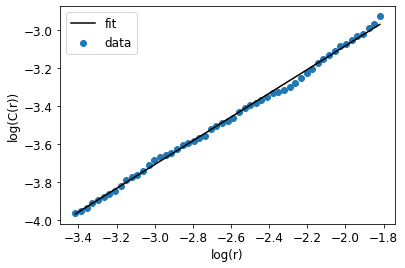

 39%|███▉      | 155/400 [1:40:37<3:00:30, 44.21s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6262941859445478
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


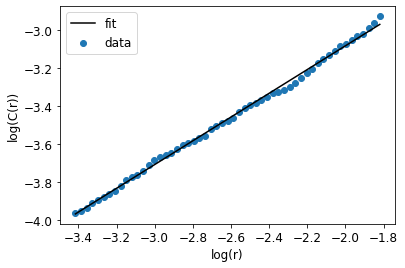

 39%|███▉      | 156/400 [1:41:21<2:59:49, 44.22s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6266922316964404
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


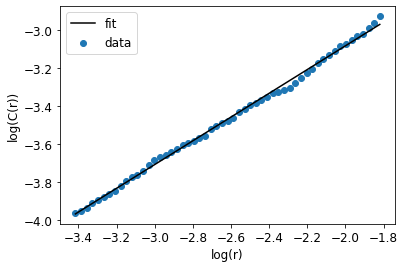

 39%|███▉      | 157/400 [1:42:06<2:59:08, 44.23s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6264345751871806
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


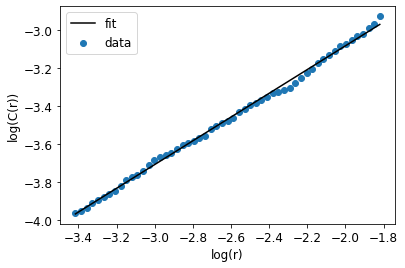

 40%|███▉      | 158/400 [1:42:50<2:58:27, 44.25s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6263995068496355
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


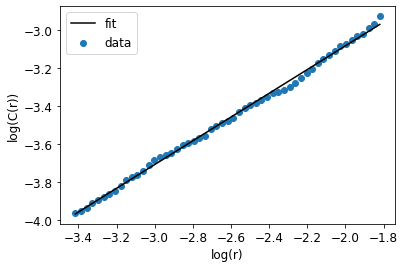

 40%|███▉      | 159/400 [1:43:34<2:57:52, 44.28s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6266745907853901
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.42
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00604
Activity number: 126.95056
**************************************************


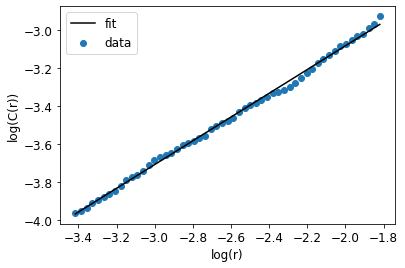

 40%|████      | 160/400 [1:44:18<2:57:06, 44.28s/it]

0    2.358974
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6266756576136548
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


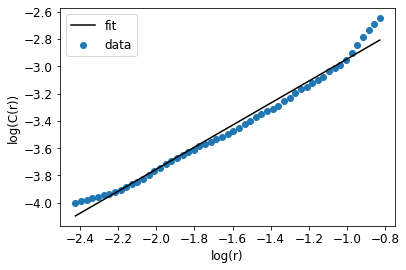

 40%|████      | 161/400 [1:44:19<2:03:43, 31.06s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8072315271331828
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


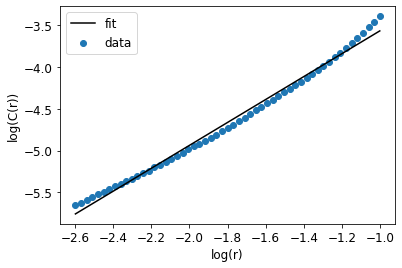

 40%|████      | 162/400 [1:44:21<1:28:28, 22.30s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.369065551718515
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


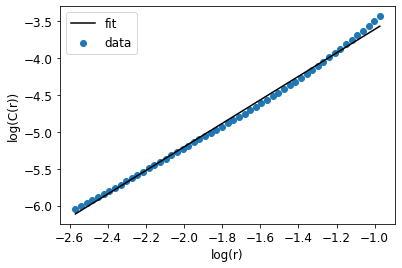

 41%|████      | 163/400 [1:44:37<1:20:38, 20.42s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5960482483004061
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


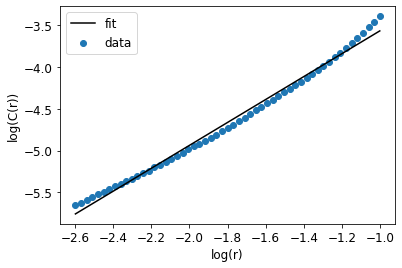

 41%|████      | 164/400 [1:44:38<58:24, 14.85s/it]  

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.369065551718515
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


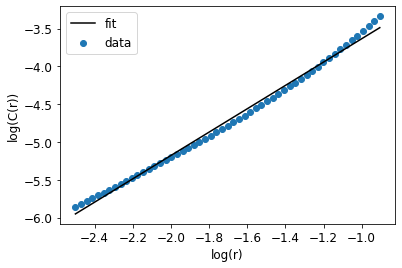

 41%|████▏     | 165/400 [1:44:44<47:02, 12.01s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5445799882712072
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


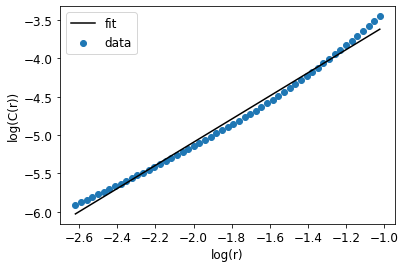

 42%|████▏     | 166/400 [1:44:49<39:20, 10.09s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.50943549237463
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


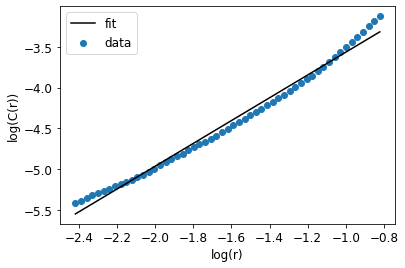

 42%|████▏     | 167/400 [1:44:51<28:48,  7.42s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.399288248062913
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


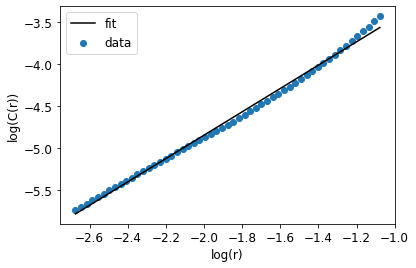

 42%|████▏     | 168/400 [1:44:57<26:58,  6.98s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.389477091374427
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


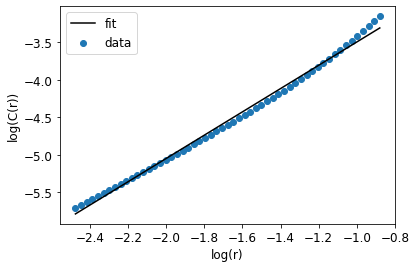

 42%|████▏     | 169/400 [1:45:00<22:53,  5.95s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5538043389212228
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00719
Activity number: 151.09877
**************************************************


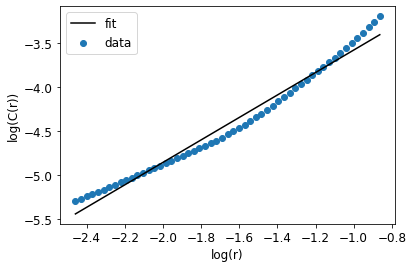

 42%|████▎     | 170/400 [1:45:02<17:35,  4.59s/it]

0    2.807692
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2763657124231054
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


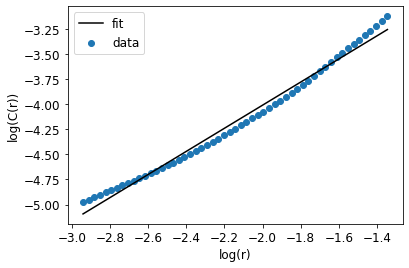

 43%|████▎     | 171/400 [1:45:07<18:39,  4.89s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1504684468240511
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


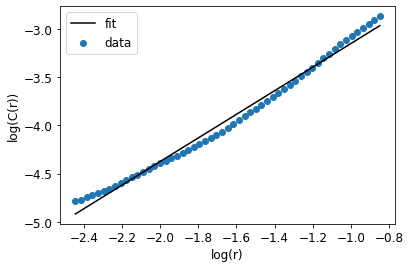

 43%|████▎     | 172/400 [1:45:08<13:29,  3.55s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2229089113781741
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


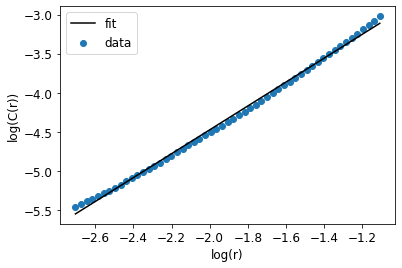

 43%|████▎     | 173/400 [1:45:10<11:45,  3.11s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5271416792297359
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


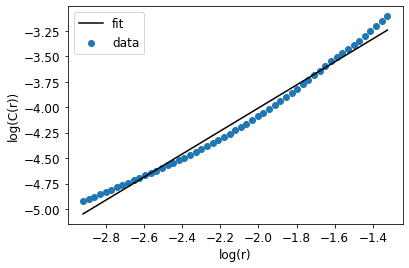

 44%|████▎     | 174/400 [1:45:20<20:22,  5.41s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1302369692376049
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


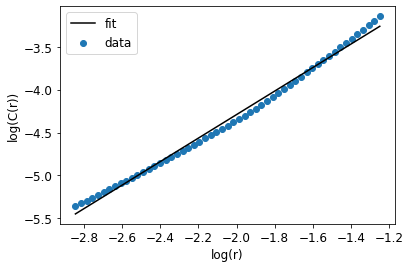

 44%|████▍     | 175/400 [1:45:23<16:40,  4.45s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.368930575497051
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


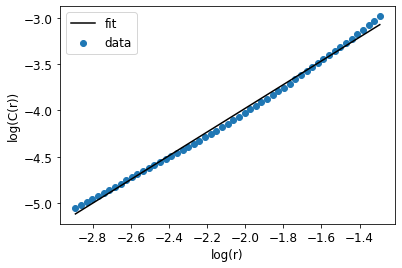

 44%|████▍     | 176/400 [1:45:31<20:31,  5.50s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.27843485963237
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


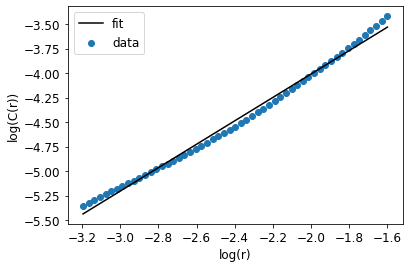

 44%|████▍     | 177/400 [1:46:15<1:03:42, 17.14s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1941357102595809
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


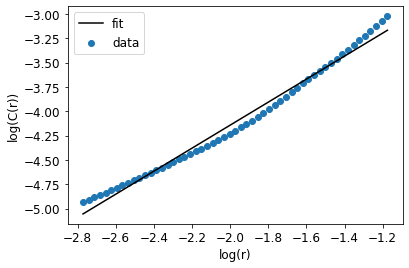

 44%|████▍     | 178/400 [1:46:18<47:21, 12.80s/it]  

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1816696710580799
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


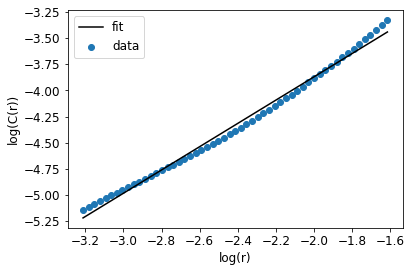

 45%|████▍     | 179/400 [1:47:03<1:22:49, 22.49s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.113795340366711
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.45
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00571
Activity number: 120.05108
**************************************************


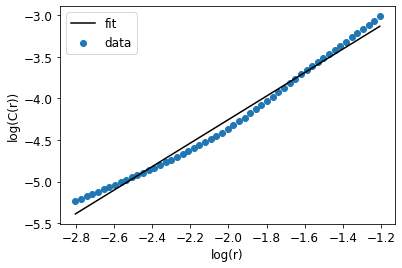

 45%|████▌     | 180/400 [1:47:05<1:00:41, 16.55s/it]

0    2.230769
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4126171353323123
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


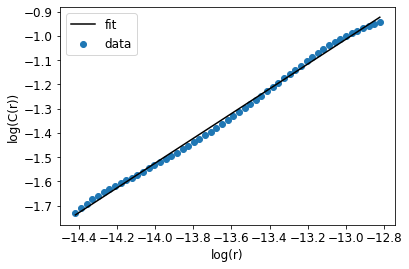

 45%|████▌     | 181/400 [1:47:50<1:31:35, 25.10s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.511065580373724
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


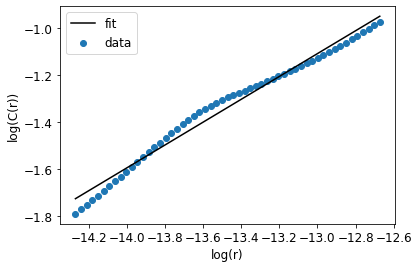

 46%|████▌     | 182/400 [1:48:36<1:53:04, 31.12s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.48567343607565033
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


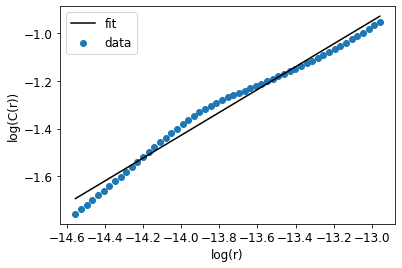

 46%|████▌     | 183/400 [1:49:21<2:07:40, 35.30s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4784423148706137
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


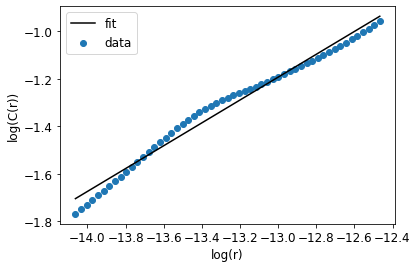

 46%|████▌     | 184/400 [1:50:05<2:16:38, 37.96s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.48103432294058657
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


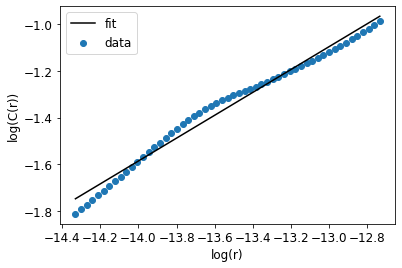

 46%|████▋     | 185/400 [1:50:49<2:22:50, 39.86s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.49021596685785257
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


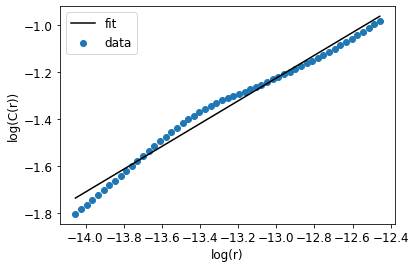

 46%|████▋     | 186/400 [1:51:33<2:26:30, 41.08s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4837072999507148
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


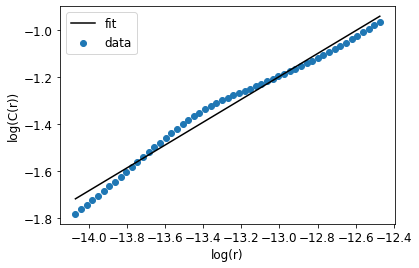

 47%|████▋     | 187/400 [1:52:17<2:28:51, 41.93s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.48758476422501873
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


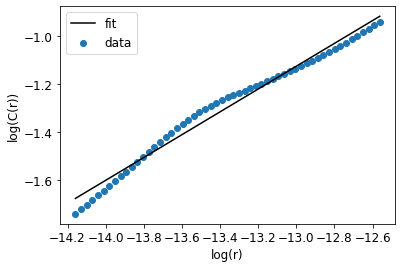

 47%|████▋     | 188/400 [1:53:01<2:30:22, 42.56s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.47516465174496625
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


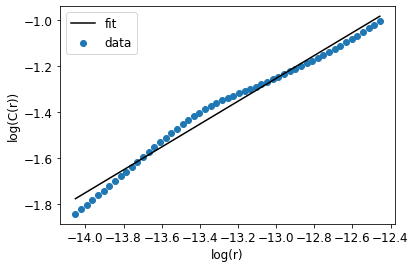

 47%|████▋     | 189/400 [1:53:45<2:30:48, 42.89s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.49629673533339463
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.13
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00226
Activity number: 47.60646
**************************************************


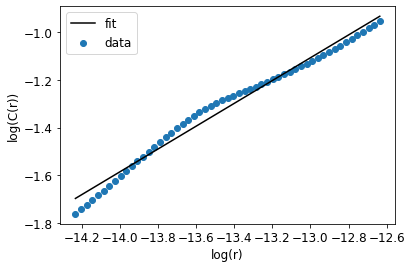

 48%|████▊     | 190/400 [1:54:28<2:30:54, 43.12s/it]

0    0.884615
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.47852195193035574
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


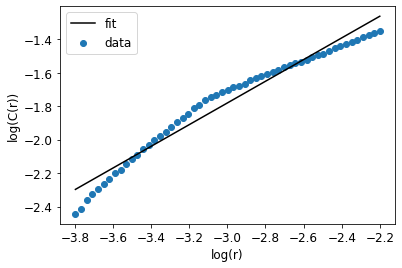

 48%|████▊     | 191/400 [1:55:12<2:30:57, 43.34s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6482960419712448
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


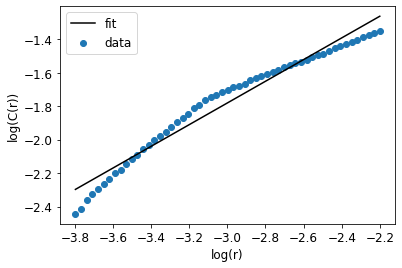

 48%|████▊     | 192/400 [1:55:56<2:30:45, 43.49s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.648302778420134
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


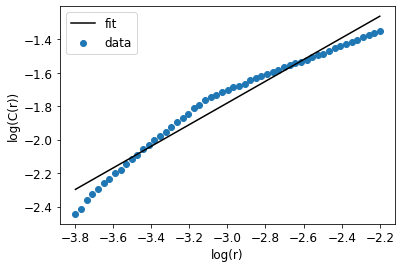

 48%|████▊     | 193/400 [1:56:40<2:30:19, 43.57s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6482937782189937
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


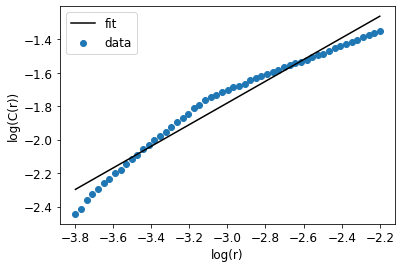

 48%|████▊     | 194/400 [1:57:24<2:30:04, 43.71s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6482937782189937
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


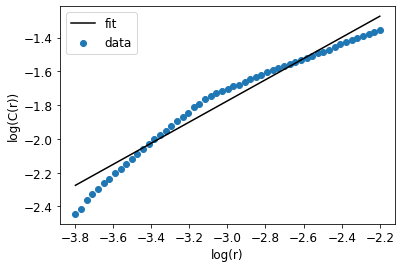

 49%|████▉     | 195/400 [1:58:08<2:29:51, 43.86s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6270981742658345
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


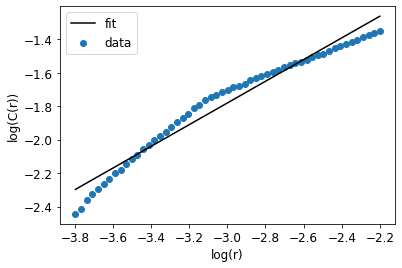

 49%|████▉     | 196/400 [1:58:52<2:29:28, 43.97s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6483016617717359
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


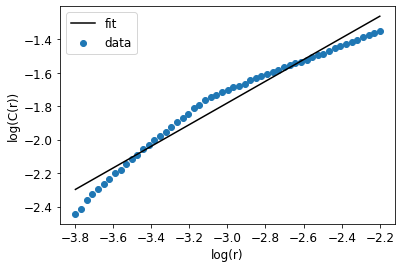

 49%|████▉     | 197/400 [1:59:36<2:29:06, 44.07s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6483003775181664
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


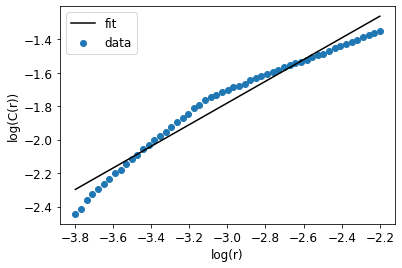

 50%|████▉     | 198/400 [2:00:20<2:28:02, 43.97s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6482981622166005
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


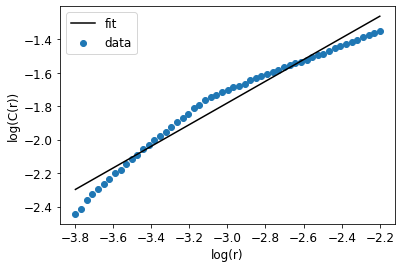

 50%|████▉     | 199/400 [2:01:04<2:27:37, 44.07s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6483109617746683
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.83
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00309
Activity number: 64.85518
**************************************************


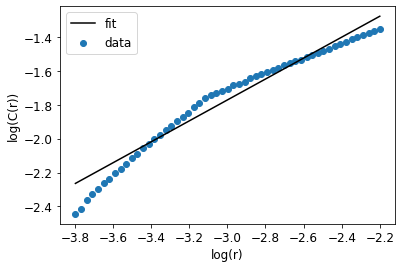

 50%|█████     | 200/400 [2:01:49<2:26:53, 44.07s/it]

0    1.205128
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.617508450492744
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


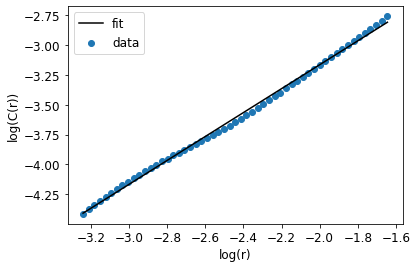

 50%|█████     | 201/400 [2:02:33<2:26:22, 44.13s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.002445666648646
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


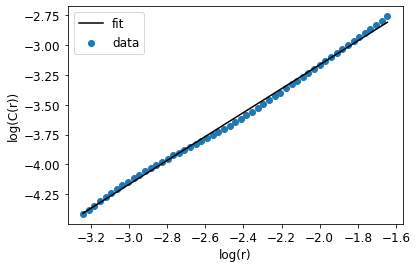

 50%|█████     | 202/400 [2:03:17<2:25:50, 44.20s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0024487791735472
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


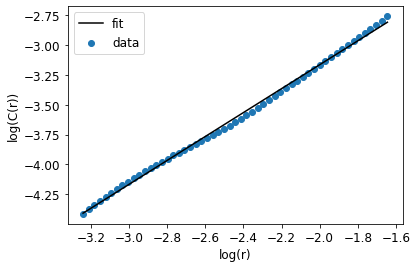

 51%|█████     | 203/400 [2:04:02<2:25:19, 44.26s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0034012272381314
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


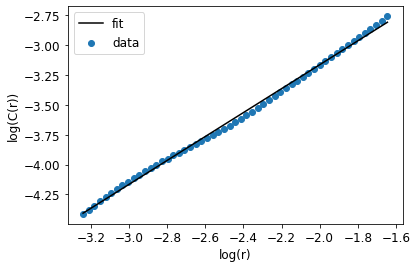

 51%|█████     | 204/400 [2:04:46<2:24:43, 44.30s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0025921115977405
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


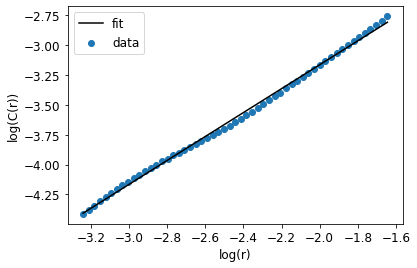

 51%|█████▏    | 205/400 [2:05:31<2:24:17, 44.40s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.002576325317941
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


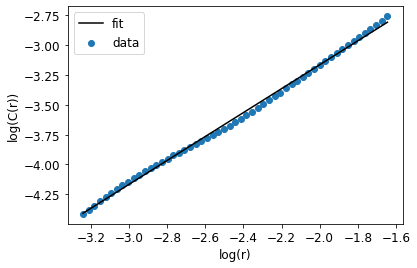

 52%|█████▏    | 206/400 [2:06:15<2:23:18, 44.32s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0024711797593566
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


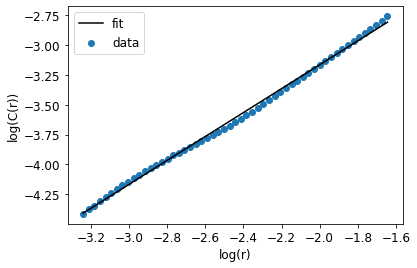

 52%|█████▏    | 207/400 [2:06:59<2:22:46, 44.38s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0034128291807745
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


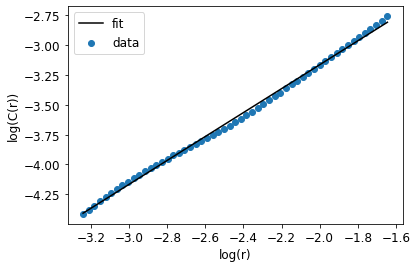

 52%|█████▏    | 208/400 [2:07:44<2:22:36, 44.57s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0024492230239626
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


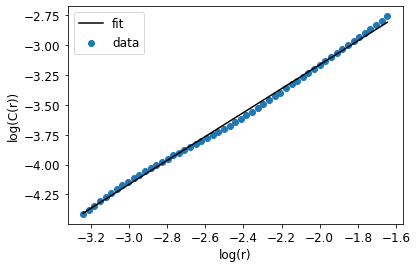

 52%|█████▏    | 209/400 [2:08:29<2:21:49, 44.55s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0025984371209014
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.72
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00358
Activity number: 75.20441
**************************************************


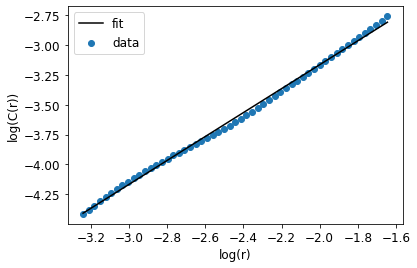

 52%|█████▎    | 210/400 [2:09:13<2:20:52, 44.49s/it]

0    1.397436
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0036292118994343
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


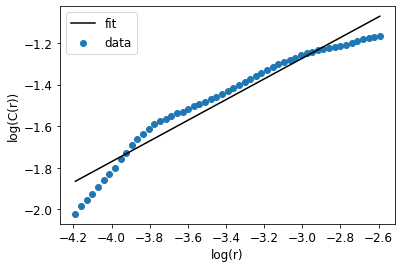

 53%|█████▎    | 211/400 [2:09:58<2:20:14, 44.52s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4972833963037873
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


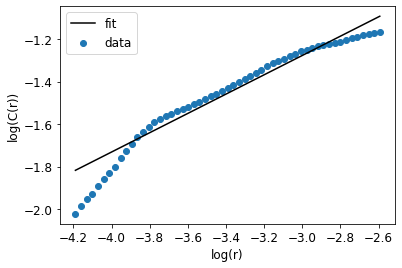

 53%|█████▎    | 212/400 [2:10:42<2:19:18, 44.46s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.45343764105318696
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


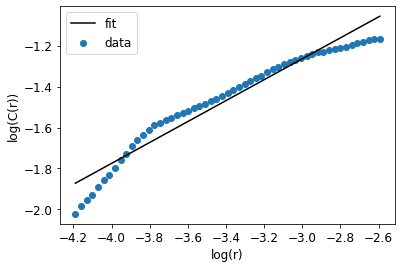

 53%|█████▎    | 213/400 [2:11:26<2:17:53, 44.24s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.5108018091128064
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


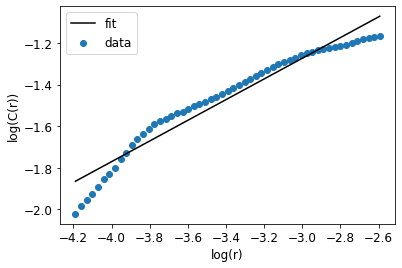

 54%|█████▎    | 214/400 [2:12:09<2:16:35, 44.06s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4972900318172215
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


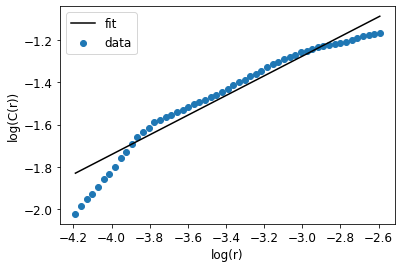

 54%|█████▍    | 215/400 [2:12:54<2:16:00, 44.11s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4646154720482653
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


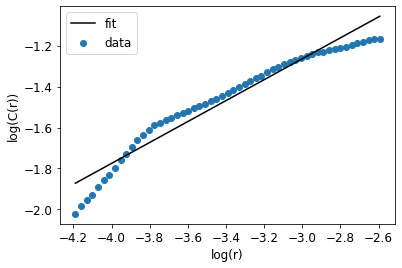

 54%|█████▍    | 216/400 [2:13:38<2:15:13, 44.09s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.510797612558001
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


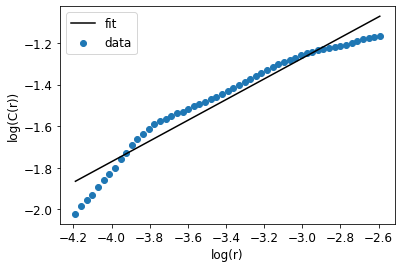

 54%|█████▍    | 217/400 [2:14:22<2:14:47, 44.20s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.49727993395889264
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


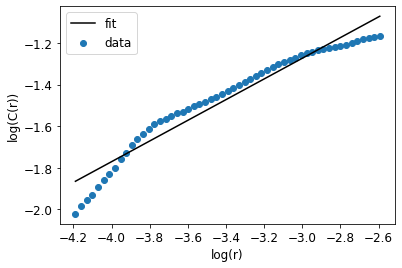

 55%|█████▍    | 218/400 [2:15:06<2:14:05, 44.21s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4972716094642461
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


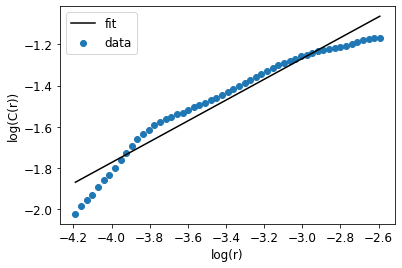

 55%|█████▍    | 219/400 [2:15:50<2:13:08, 44.14s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.5040910813249312
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.88
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00292
Activity number: 61.40544
**************************************************


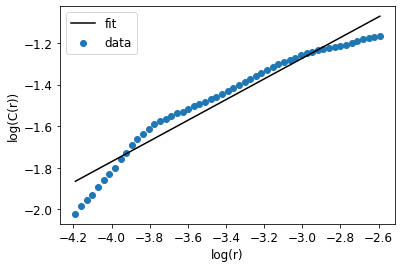

 55%|█████▌    | 220/400 [2:16:35<2:12:36, 44.20s/it]

0    1.141026
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.49727896821384543
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


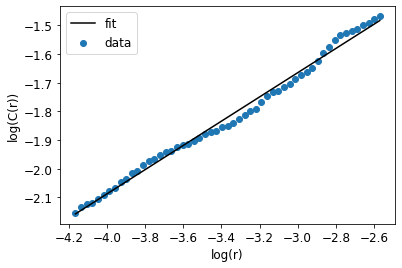

 55%|█████▌    | 221/400 [2:17:19<2:11:43, 44.16s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42271991135697967
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


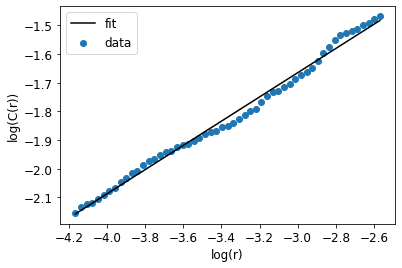

 56%|█████▌    | 222/400 [2:18:03<2:11:25, 44.30s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42274429888795717
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


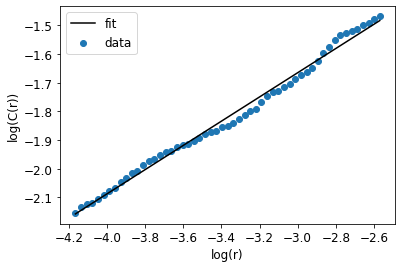

 56%|█████▌    | 223/400 [2:18:48<2:10:48, 44.34s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4227319474478191
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


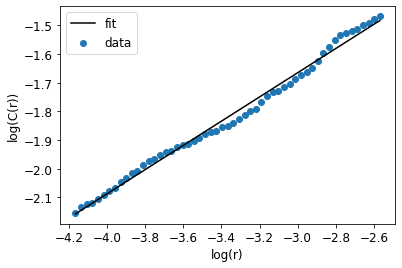

 56%|█████▌    | 224/400 [2:19:32<2:10:11, 44.39s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42274047511508783
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


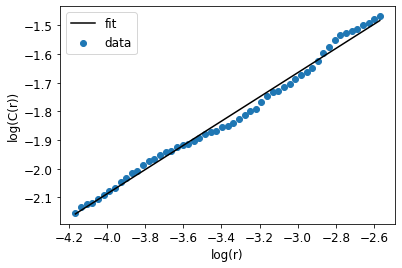

 56%|█████▋    | 225/400 [2:20:17<2:09:22, 44.36s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4227402603138487
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


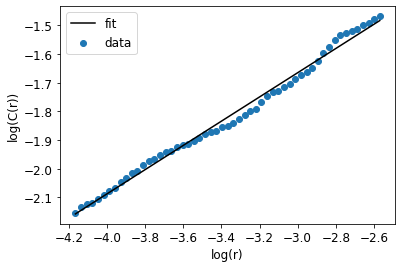

 56%|█████▋    | 226/400 [2:21:01<2:08:22, 44.27s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42272498235635547
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


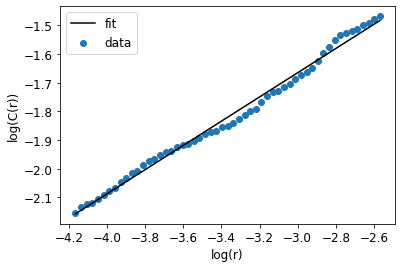

 57%|█████▋    | 227/400 [2:21:45<2:07:49, 44.33s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4227331401645637
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


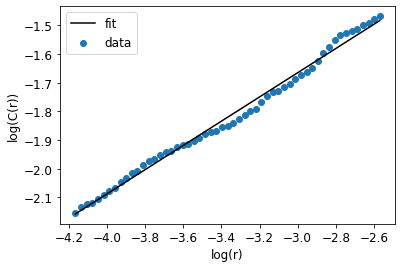

 57%|█████▋    | 228/400 [2:22:30<2:07:16, 44.40s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42273871198075746
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


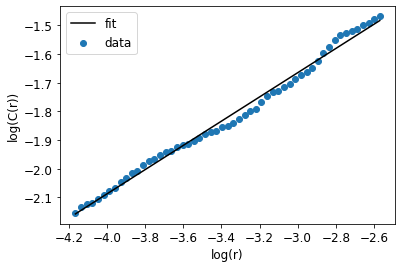

 57%|█████▋    | 229/400 [2:23:14<2:06:05, 44.24s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42274545863020285
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.39
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00653
Activity number: 137.29979
**************************************************


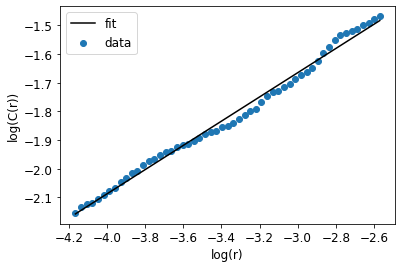

 57%|█████▊    | 230/400 [2:23:58<2:05:18, 44.23s/it]

0    2.551282
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.42275325692098503
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


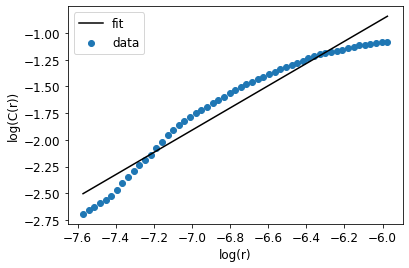

 58%|█████▊    | 231/400 [2:24:41<2:04:08, 44.08s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0400323825481474
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


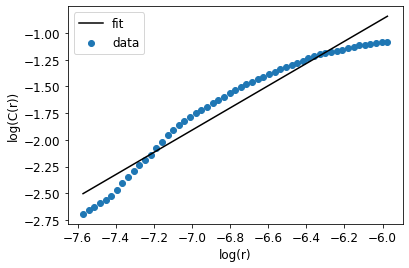

 58%|█████▊    | 232/400 [2:25:25<2:03:20, 44.05s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0398845013745892
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


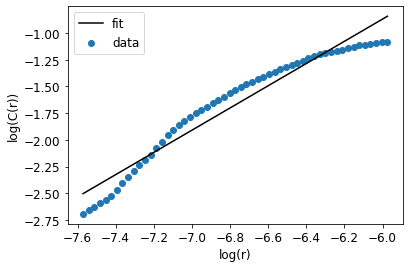

 58%|█████▊    | 233/400 [2:26:10<2:02:44, 44.10s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0399444470278587
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


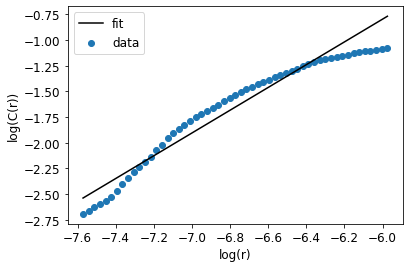

 58%|█████▊    | 234/400 [2:26:54<2:02:21, 44.22s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1084808595327522
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


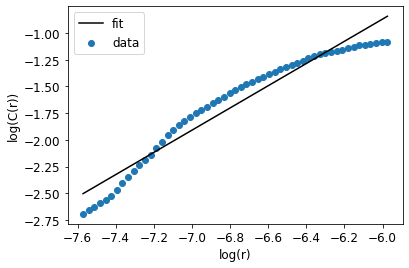

 59%|█████▉    | 235/400 [2:27:39<2:01:48, 44.30s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0399211889167315
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


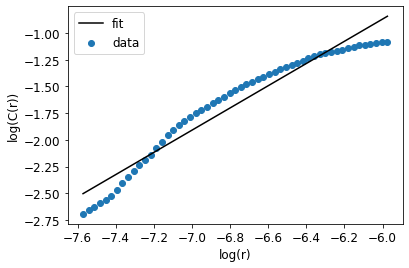

 59%|█████▉    | 236/400 [2:28:23<2:01:07, 44.31s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0398913304948285
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


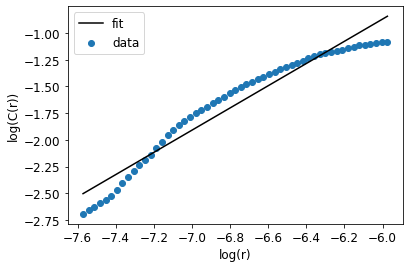

 59%|█████▉    | 237/400 [2:29:08<2:00:35, 44.39s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0398437196363626
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


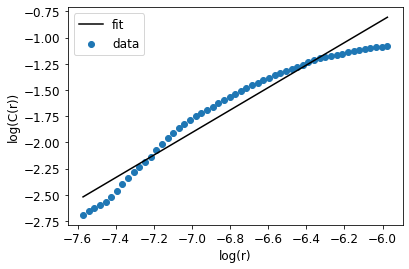

 60%|█████▉    | 238/400 [2:29:52<1:59:58, 44.43s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0738907495587766
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


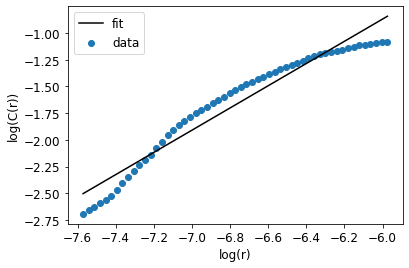

 60%|█████▉    | 239/400 [2:30:37<1:59:23, 44.49s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0399497454439393
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.99
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00259
Activity number: 54.50595
**************************************************


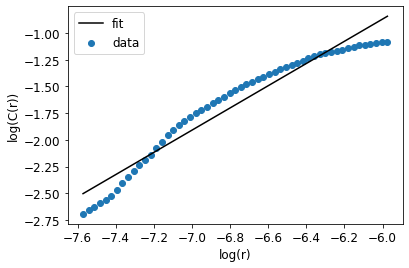

 60%|██████    | 240/400 [2:31:22<1:59:03, 44.65s/it]

0    1.012821
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0398568068793024
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


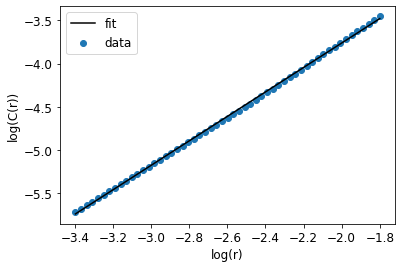

 60%|██████    | 241/400 [2:32:07<1:58:33, 44.74s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4138343189537785
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


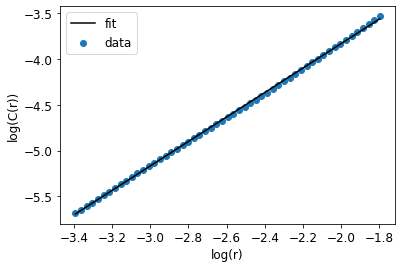

 60%|██████    | 242/400 [2:32:51<1:57:20, 44.56s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3322851629966472
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


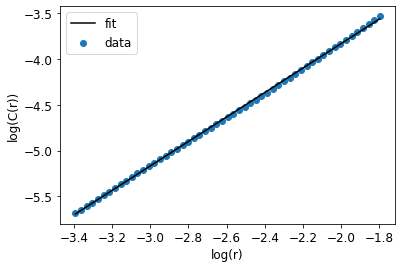

 61%|██████    | 243/400 [2:33:35<1:56:21, 44.47s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3322851629966472
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


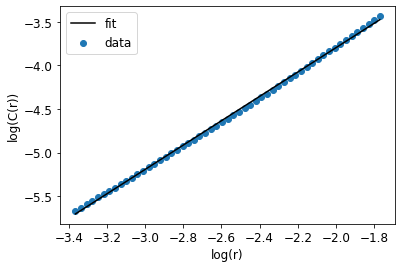

 61%|██████    | 244/400 [2:34:19<1:55:23, 44.38s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3951446599209367
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


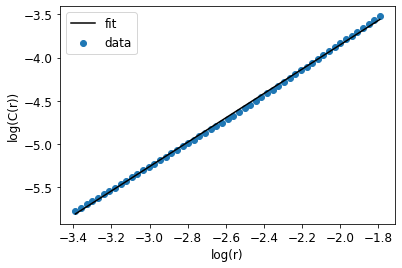

 61%|██████▏   | 245/400 [2:35:04<1:54:36, 44.37s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4098334848357785
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


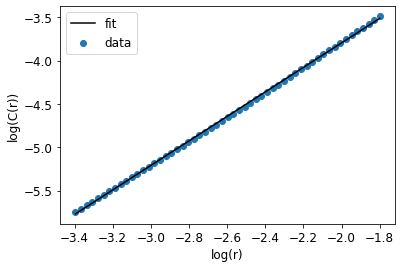

 62%|██████▏   | 246/400 [2:35:48<1:53:56, 44.39s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4143376447379927
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


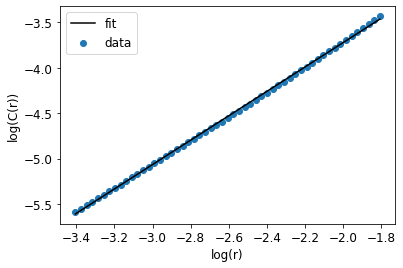

 62%|██████▏   | 247/400 [2:36:32<1:52:47, 44.23s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3435043946223382
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


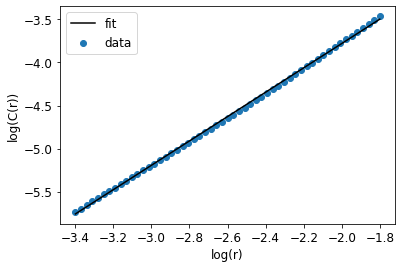

 62%|██████▏   | 248/400 [2:37:16<1:51:46, 44.12s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4166522836561262
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


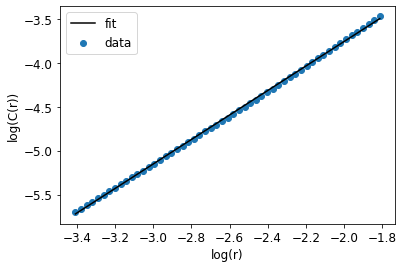

 62%|██████▏   | 249/400 [2:38:00<1:51:03, 44.13s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3931287887153123
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.44
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00588
Activity number: 123.50082
**************************************************


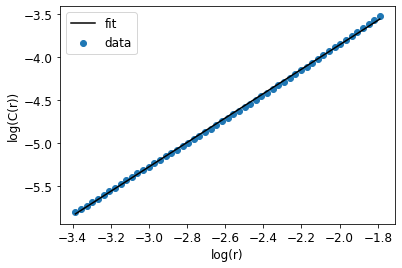

 62%|██████▎   | 250/400 [2:38:44<1:50:15, 44.11s/it]

0    2.294872
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4170964505805994
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


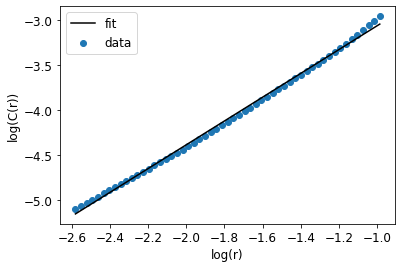

 63%|██████▎   | 251/400 [2:38:47<1:18:42, 31.69s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3181400044756737
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


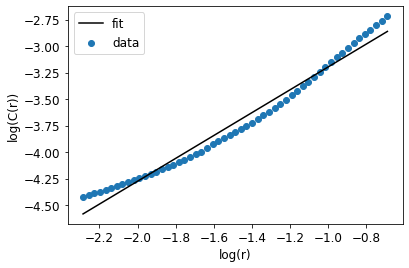

 63%|██████▎   | 252/400 [2:38:47<55:03, 22.32s/it]  

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.078681558044918
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


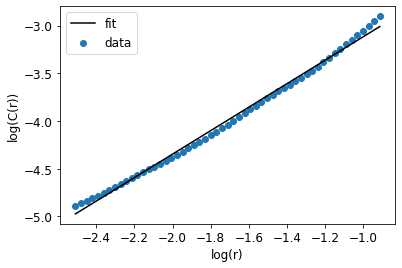

 63%|██████▎   | 253/400 [2:38:48<38:58, 15.91s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2306145015607546
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


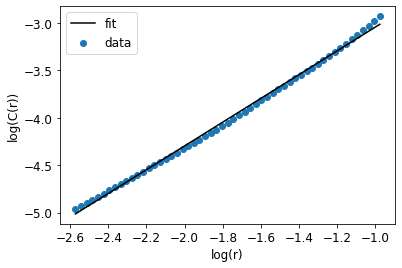

 64%|██████▎   | 254/400 [2:38:50<28:35, 11.75s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.253906175636235
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


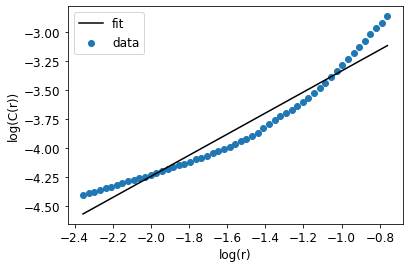

 64%|██████▍   | 255/400 [2:38:51<20:09,  8.34s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.909693500760404
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


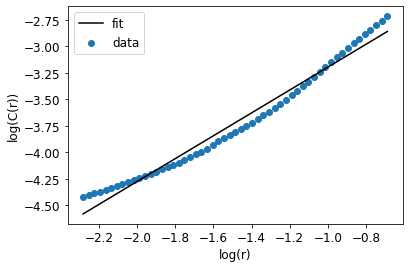

 64%|██████▍   | 256/400 [2:38:51<14:20,  5.98s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0802491395725677
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


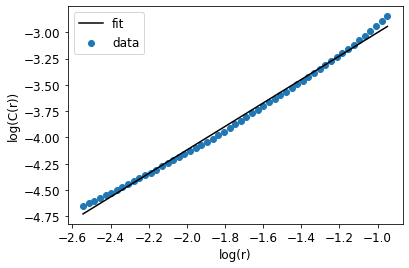

 64%|██████▍   | 257/400 [2:38:52<10:55,  4.58s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1171587236148006
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


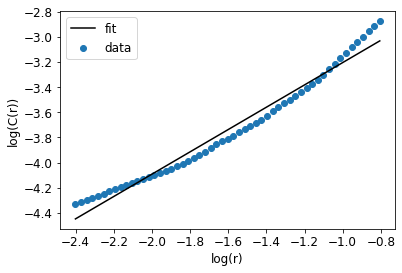

 64%|██████▍   | 258/400 [2:38:53<07:52,  3.33s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8877982008925058
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


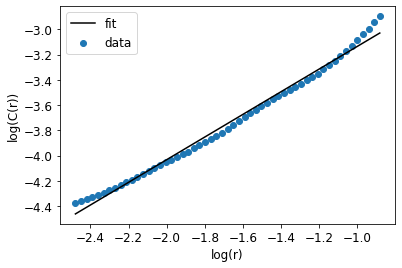

 65%|██████▍   | 259/400 [2:38:53<05:50,  2.49s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8980586117041767
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.41
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0062
Activity number: 130.40031
**************************************************


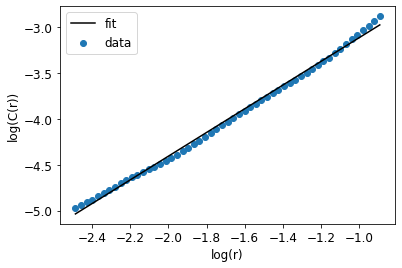

 65%|██████▌   | 260/400 [2:38:54<04:53,  2.10s/it]

0    2.423077
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2926795723988809
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


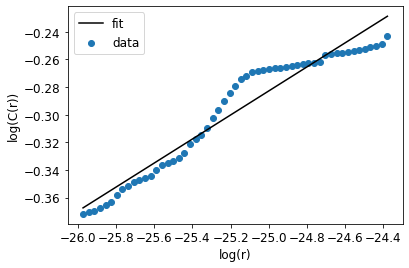

 65%|██████▌   | 261/400 [2:39:39<34:07, 14.73s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08695527628387044
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


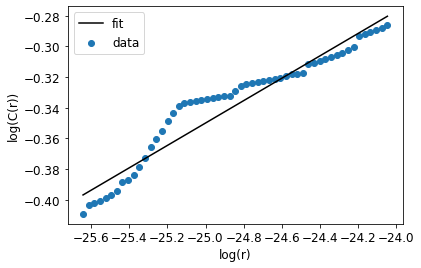

 66%|██████▌   | 262/400 [2:40:23<54:14, 23.58s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.07300438465097288
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


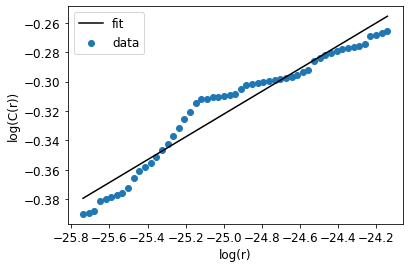

 66%|██████▌   | 263/400 [2:41:07<1:07:55, 29.75s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.07765509134873741
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


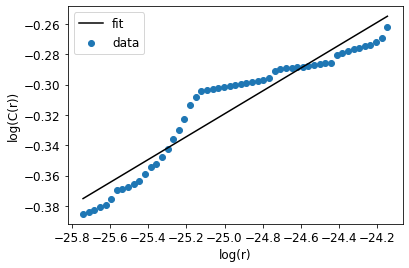

 66%|██████▌   | 264/400 [2:41:51<1:17:20, 34.12s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.07531694257693793
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


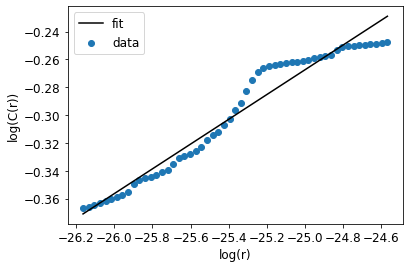

 66%|██████▋   | 265/400 [2:42:36<1:23:40, 37.19s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08901630522228084
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


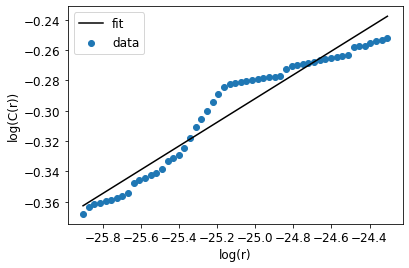

 66%|██████▋   | 266/400 [2:43:20<1:27:31, 39.19s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.07825086476537567
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


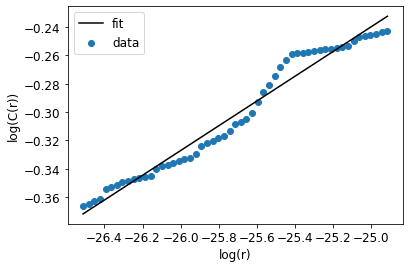

 67%|██████▋   | 267/400 [2:44:03<1:29:56, 40.57s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08742711142777526
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


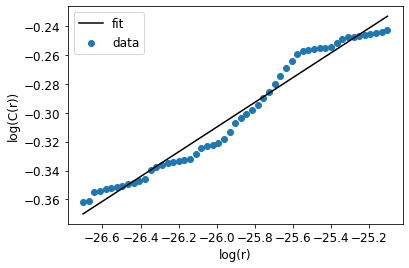

 67%|██████▋   | 268/400 [2:44:47<1:31:35, 41.63s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.085639345389133
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


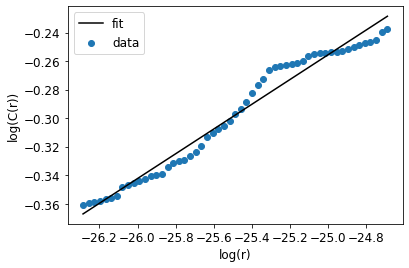

 67%|██████▋   | 269/400 [2:45:32<1:32:44, 42.48s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08685246515717725
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.32
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00194
Activity number: 40.70697
**************************************************


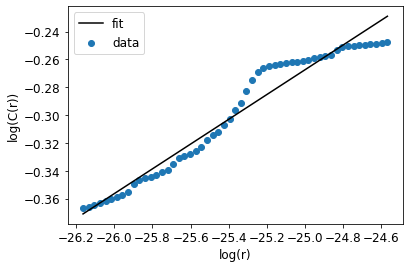

 68%|██████▊   | 270/400 [2:46:16<1:33:13, 43.03s/it]

0    0.75641
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08901630522228084
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


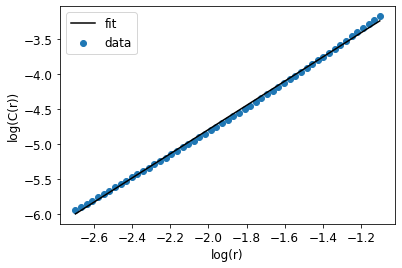

 68%|██████▊   | 271/400 [2:46:32<1:14:49, 34.80s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7325992611078902
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


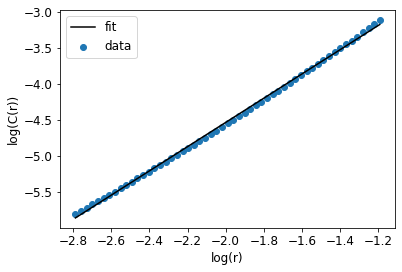

 68%|██████▊   | 272/400 [2:46:48<1:02:15, 29.18s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6857098713124035
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


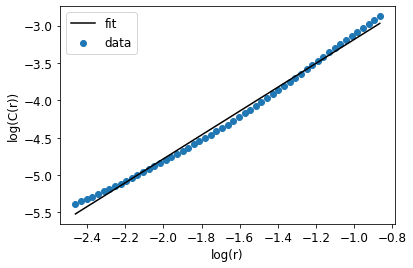

 68%|██████▊   | 273/400 [2:46:49<43:49, 20.70s/it]  

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5961244962245975
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


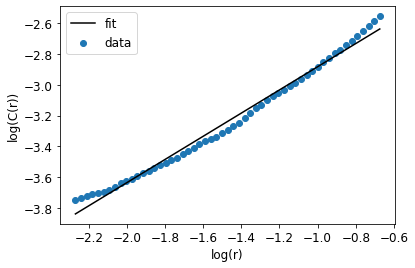

 68%|██████▊   | 274/400 [2:46:49<30:34, 14.56s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.7509633940825583
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


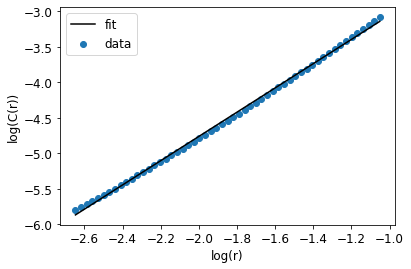

 69%|██████▉   | 275/400 [2:46:56<25:41, 12.33s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.706925081467344
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


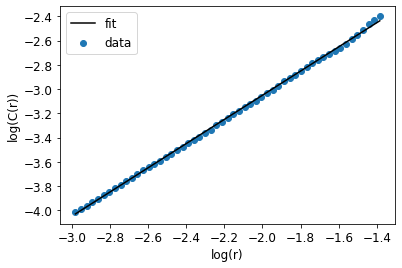

 69%|██████▉   | 276/400 [2:47:40<45:14, 21.89s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9968919853719586
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


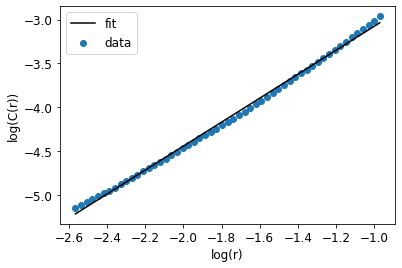

 69%|██████▉   | 277/400 [2:47:42<32:23, 15.80s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.3639718659613125
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


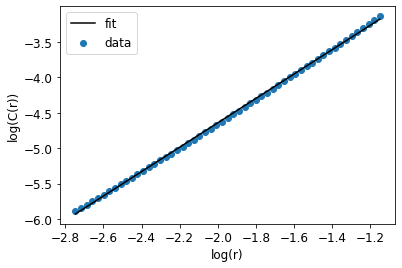

 70%|██████▉   | 278/400 [2:47:56<30:46, 15.14s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.720398170728396
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


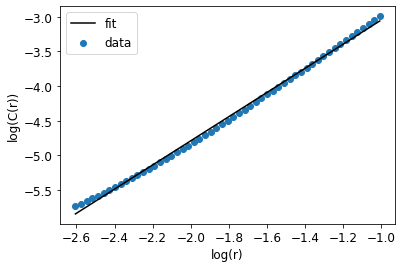

 70%|██████▉   | 279/400 [2:47:58<23:04, 11.44s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7421451158414272
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.48
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00538
Activity number: 113.15159
**************************************************


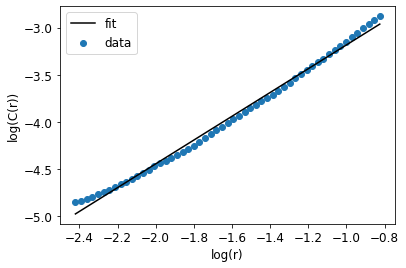

 70%|███████   | 280/400 [2:47:59<16:17,  8.15s/it]

0    2.102564
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.261409753794001
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


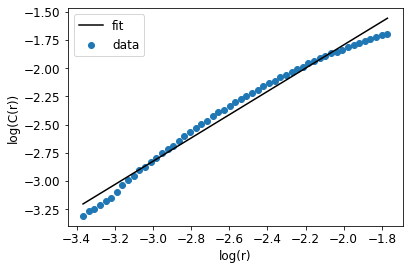

 70%|███████   | 281/400 [2:48:44<37:58, 19.15s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0315128796333939
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


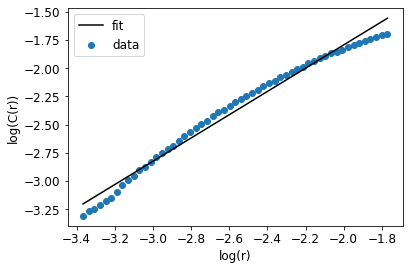

 70%|███████   | 282/400 [2:49:29<53:01, 26.96s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0314903646224145
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


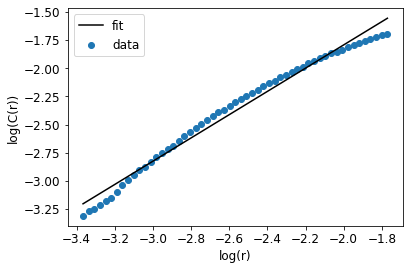

 71%|███████   | 283/400 [2:50:14<1:03:21, 32.49s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.03145383798745
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


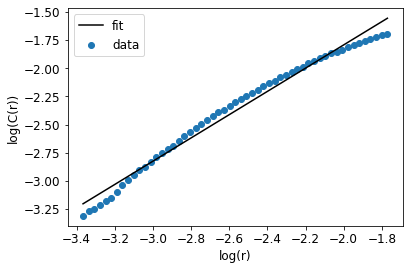

 71%|███████   | 284/400 [2:50:59<1:09:53, 36.15s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.03145383798745
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


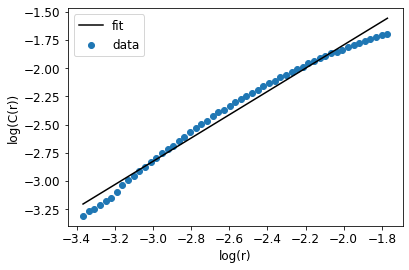

 71%|███████▏  | 285/400 [2:51:44<1:14:26, 38.84s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0315285698721517
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


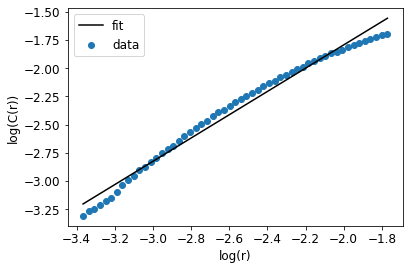

 72%|███████▏  | 286/400 [2:52:29<1:17:07, 40.59s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0315077589934052
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


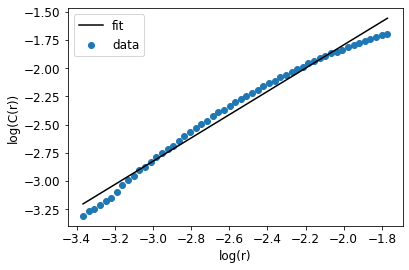

 72%|███████▏  | 287/400 [2:53:13<1:18:48, 41.84s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0314927912880831
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


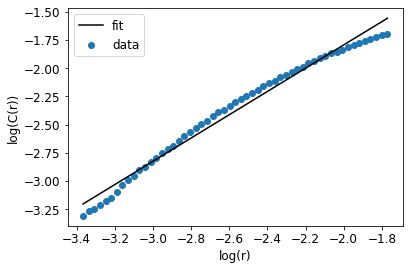

 72%|███████▏  | 288/400 [2:53:58<1:19:26, 42.56s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0315132328233316
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


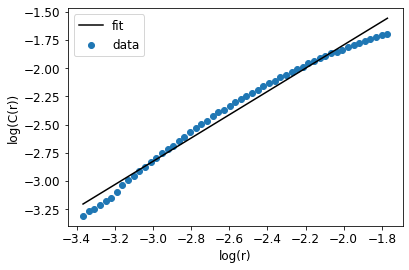

 72%|███████▏  | 289/400 [2:54:42<1:19:38, 43.05s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0315285698721517
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.75
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00341
Activity number: 71.75467
**************************************************


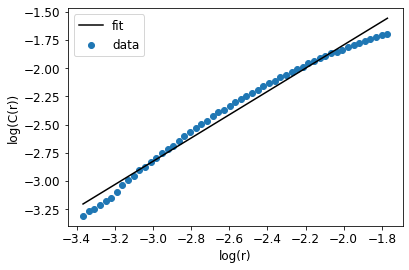

 72%|███████▎  | 290/400 [2:55:26<1:19:23, 43.30s/it]

0    1.333333
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0315216741413789
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


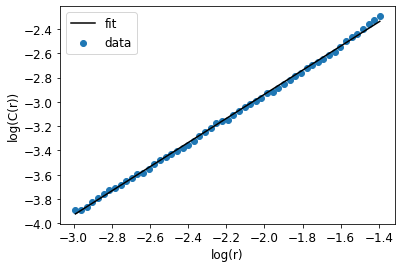

 73%|███████▎  | 291/400 [2:56:10<1:18:55, 43.44s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9924952189091011
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


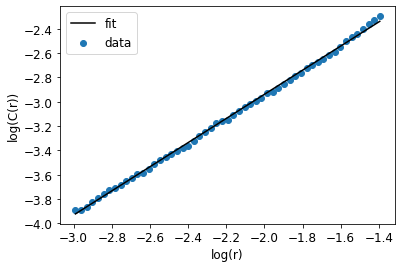

 73%|███████▎  | 292/400 [2:56:53<1:18:18, 43.51s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.99259679698452
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


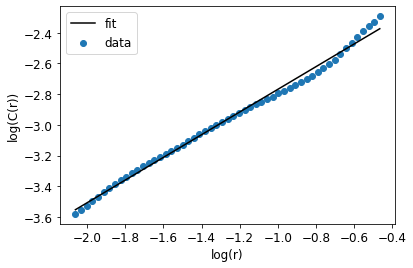

 73%|███████▎  | 293/400 [2:56:54<54:27, 30.54s/it]  

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.7384886700011803
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


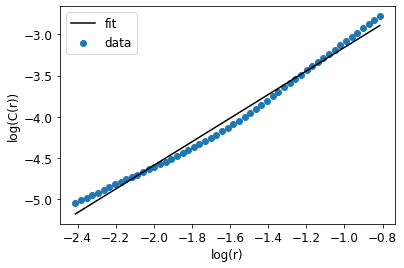

 74%|███████▎  | 294/400 [2:56:54<38:10, 21.61s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4351259535402139
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


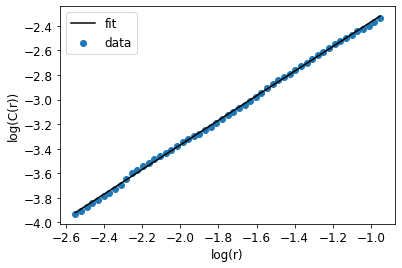

 74%|███████▍  | 295/400 [2:56:55<26:35, 15.20s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0014111653256845
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


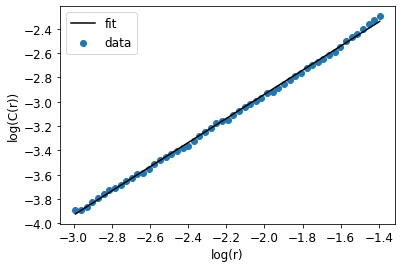

 74%|███████▍  | 296/400 [2:57:38<41:13, 23.78s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9925767810028275
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


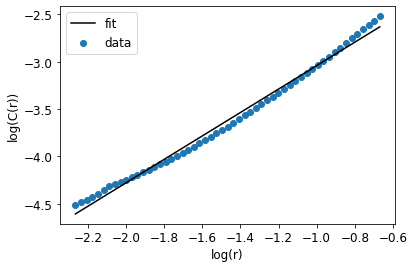

 74%|███████▍  | 297/400 [2:57:39<28:48, 16.78s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2374579708035982
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


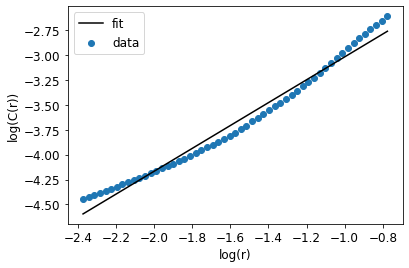

 74%|███████▍  | 298/400 [2:57:39<20:09, 11.86s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1488370836440966
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


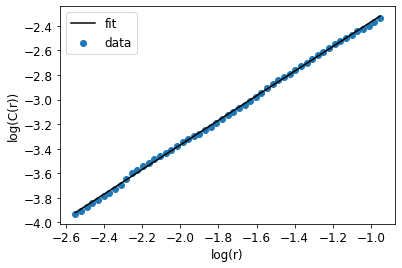

 75%|███████▍  | 299/400 [2:57:39<14:05,  8.37s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0014111653256845
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.49
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00522
Activity number: 109.70185
**************************************************


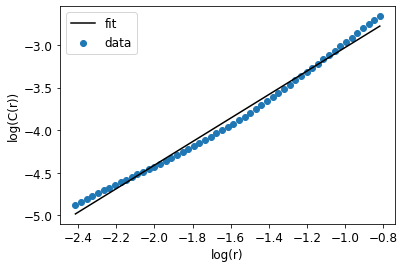

 75%|███████▌  | 300/400 [2:57:41<10:22,  6.22s/it]

0    2.038462
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.379176063365823
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


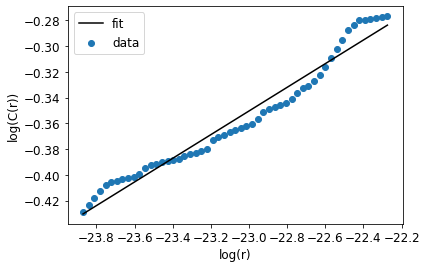

 75%|███████▌  | 301/400 [2:58:24<28:45, 17.43s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09188289592806
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


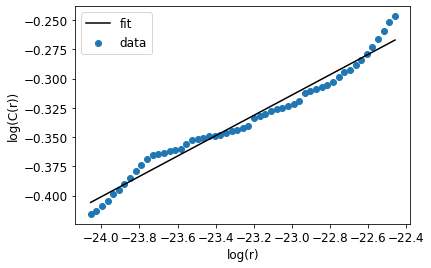

 76%|███████▌  | 302/400 [2:59:08<41:26, 25.37s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08704413915190205
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


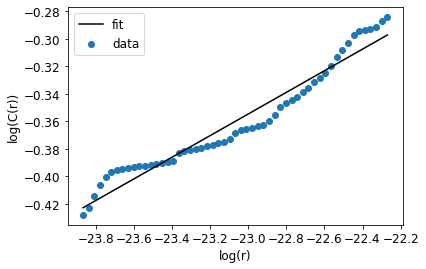

 76%|███████▌  | 303/400 [2:59:52<49:51, 30.84s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.07875288297798284
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


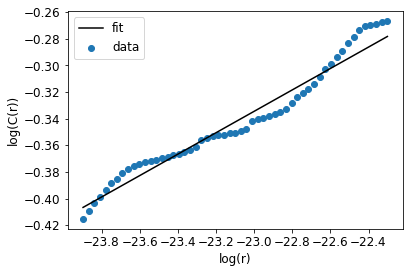

 76%|███████▌  | 304/400 [3:00:35<55:30, 34.69s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08036690829839702
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


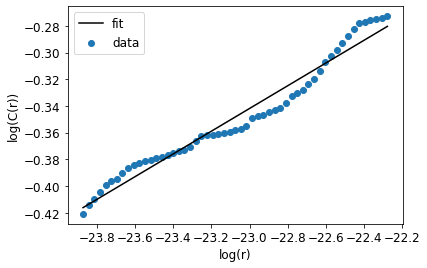

 76%|███████▋  | 305/400 [3:01:19<59:17, 37.45s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08508710393756488
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


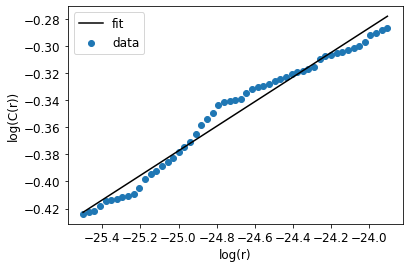

 76%|███████▋  | 306/400 [3:02:04<1:01:56, 39.54s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09088274740293359
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


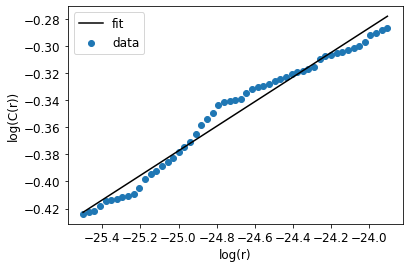

 77%|███████▋  | 307/400 [3:02:48<1:03:42, 41.10s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09088274740293359
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


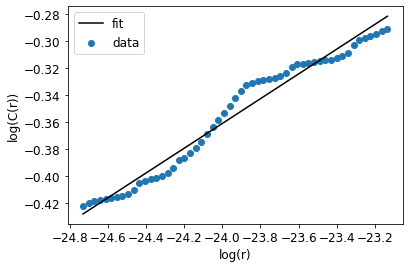

 77%|███████▋  | 308/400 [3:03:33<1:04:30, 42.07s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.09153633434414148
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


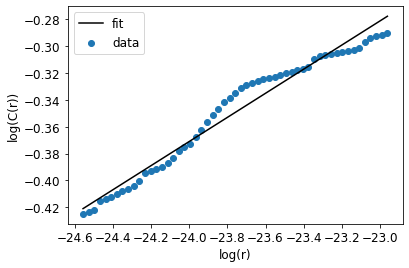

 77%|███████▋  | 309/400 [3:04:17<1:04:53, 42.78s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08981476310455819
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.22
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0021
Activity number: 44.15672
**************************************************


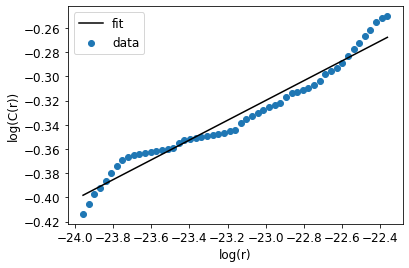

 78%|███████▊  | 310/400 [3:05:02<1:04:52, 43.25s/it]

0    0.820513
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.08170700727402132
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


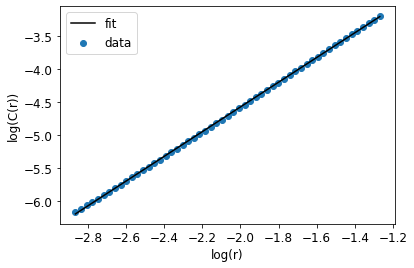

 78%|███████▊  | 311/400 [3:05:46<1:04:37, 43.57s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8749919064261626
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


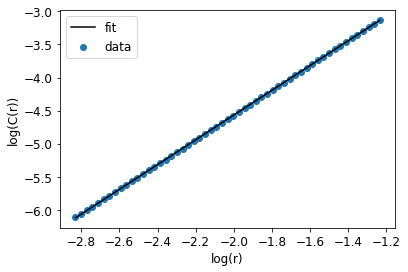

 78%|███████▊  | 312/400 [3:06:30<1:04:10, 43.76s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8722693042656766
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


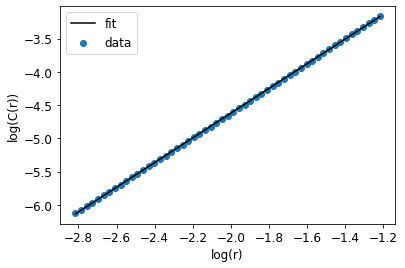

 78%|███████▊  | 313/400 [3:07:14<1:03:42, 43.93s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8592924656155105
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


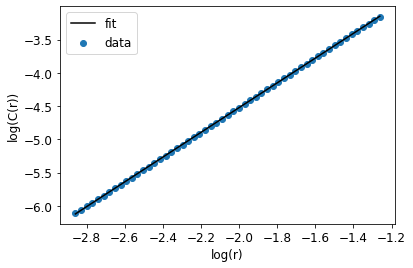

 78%|███████▊  | 314/400 [3:07:59<1:03:06, 44.03s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8616837540627702
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


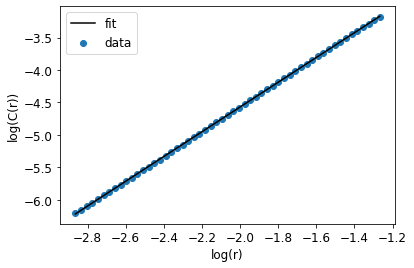

 79%|███████▉  | 315/400 [3:08:43<1:02:29, 44.11s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.9066393915024515
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


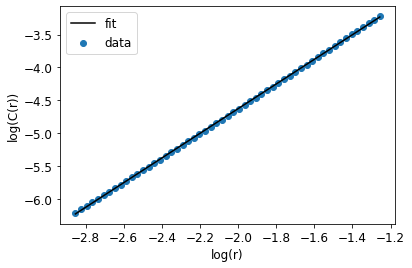

 79%|███████▉  | 316/400 [3:09:28<1:02:19, 44.52s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8785701146707103
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


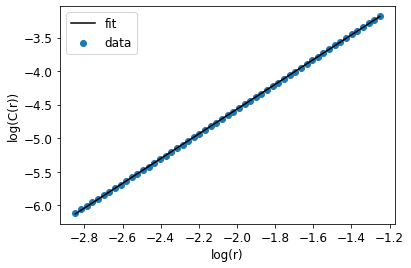

 79%|███████▉  | 317/400 [3:10:13<1:01:30, 44.46s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8441937711686862
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


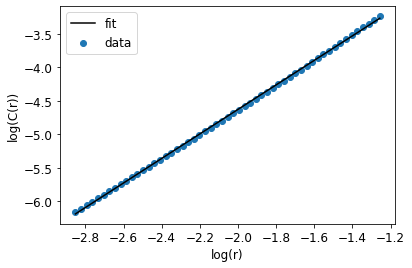

 80%|███████▉  | 318/400 [3:10:57<1:00:48, 44.50s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8318668262826232
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


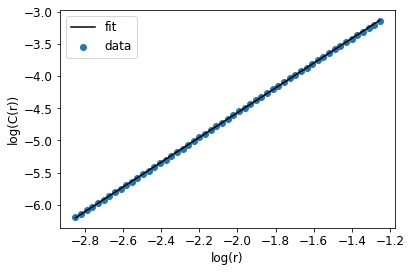

 80%|███████▉  | 319/400 [3:11:43<1:00:22, 44.72s/it]

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.9276481591699253
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.54
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00473
Activity number: 99.35262
**************************************************


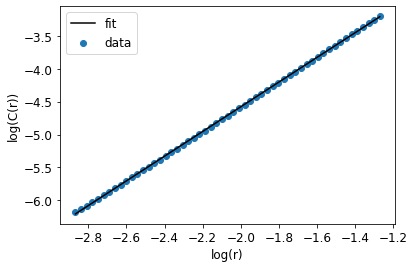

 80%|████████  | 320/400 [3:12:27<59:32, 44.65s/it]  

0    1.846154
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.8786261786855707
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


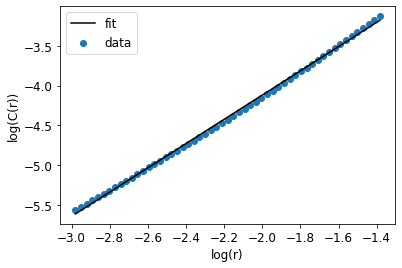

 80%|████████  | 321/400 [3:13:11<58:40, 44.57s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5247240607485306
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


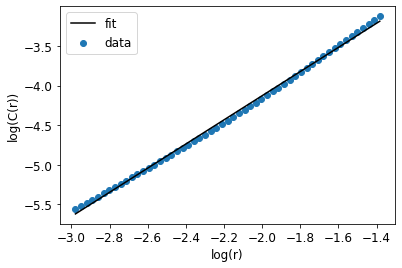

 80%|████████  | 322/400 [3:13:56<57:50, 44.49s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5239568095016576
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


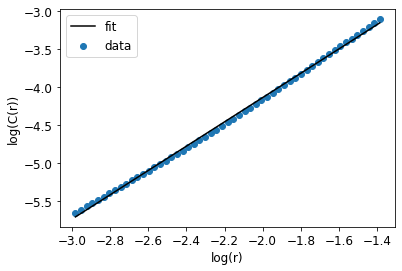

 81%|████████  | 323/400 [3:14:40<57:07, 44.52s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.59977750230785
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


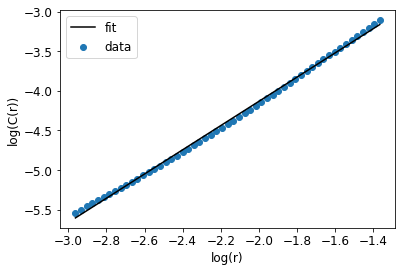

 81%|████████  | 324/400 [3:15:24<56:12, 44.38s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5285649846121687
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


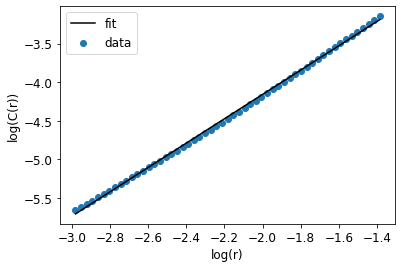

 81%|████████▏ | 325/400 [3:16:09<55:34, 44.46s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5758776519512
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


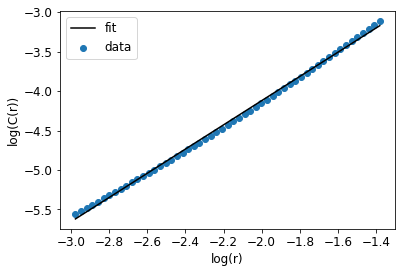

 82%|████████▏ | 326/400 [3:16:54<54:53, 44.50s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5334560967785138
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


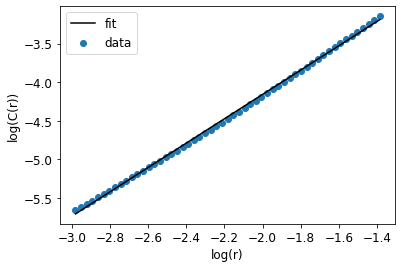

 82%|████████▏ | 327/400 [3:17:38<53:59, 44.38s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5758776519512
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


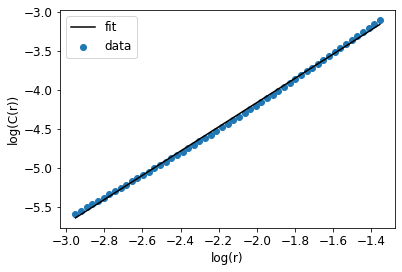

 82%|████████▏ | 328/400 [3:18:22<53:12, 44.34s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.556037589495953
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


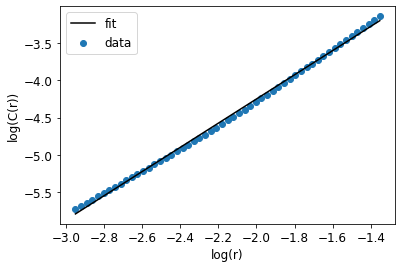

 82%|████████▏ | 329/400 [3:19:06<52:30, 44.38s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6219057530121488
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.6
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00423
Activity number: 89.00338
**************************************************


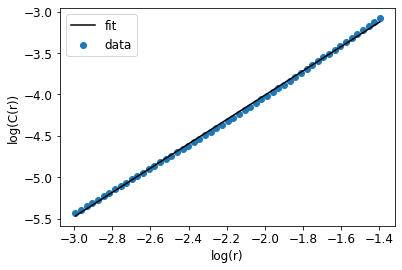

 82%|████████▎ | 330/400 [3:19:51<51:45, 44.36s/it]

0    1.653846
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.467677335316233
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


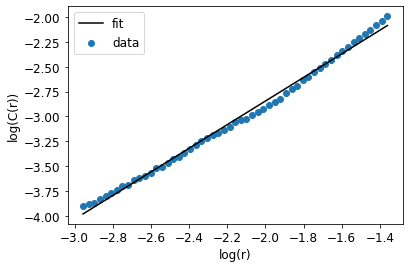

 83%|████████▎ | 331/400 [3:20:35<50:59, 44.34s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870909654239197
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


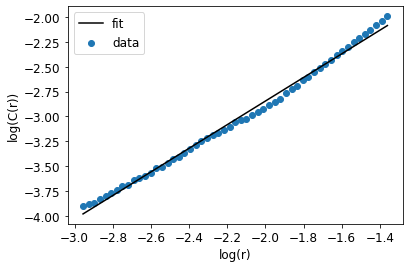

 83%|████████▎ | 332/400 [3:21:20<50:17, 44.38s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870878182103553
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


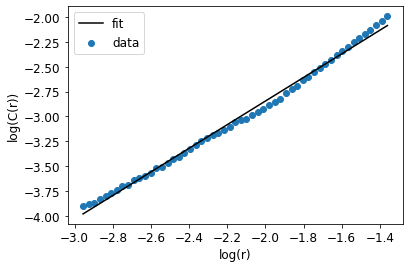

 83%|████████▎ | 333/400 [3:22:04<49:29, 44.31s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.18711147687099
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


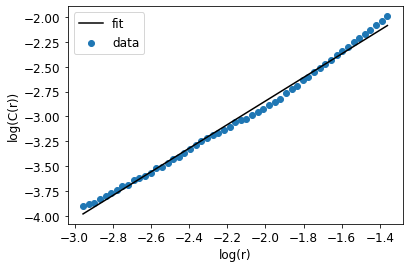

 84%|████████▎ | 334/400 [3:22:48<48:54, 44.46s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870845306342181
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


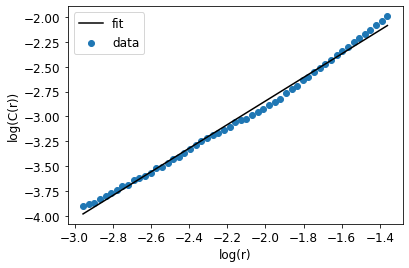

 84%|████████▍ | 335/400 [3:23:33<48:02, 44.35s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870880384270188
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


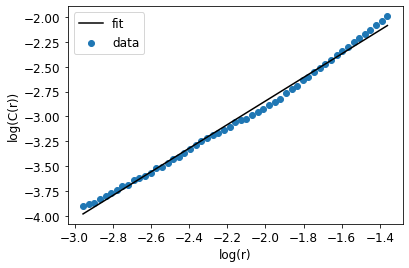

 84%|████████▍ | 336/400 [3:24:17<47:19, 44.36s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870870964649514
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


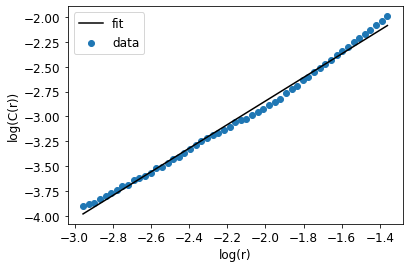

 84%|████████▍ | 337/400 [3:25:01<46:36, 44.39s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870964891954134
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


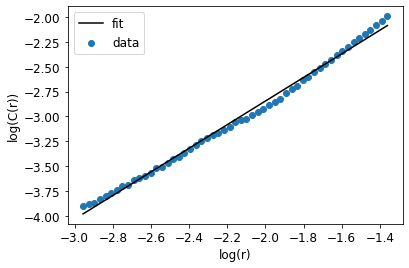

 84%|████████▍ | 338/400 [3:25:46<45:51, 44.37s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870852541218317
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


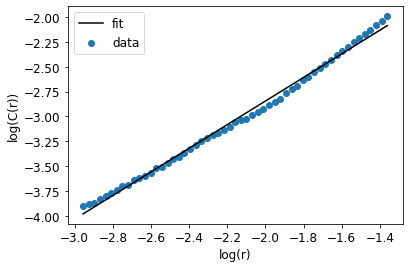

 85%|████████▍ | 339/400 [3:26:30<45:05, 44.35s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870793234580763
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.52
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00489
Activity number: 102.80236
**************************************************


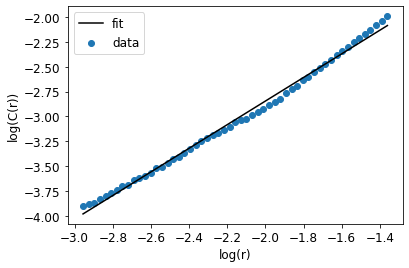

 85%|████████▌ | 340/400 [3:27:14<44:16, 44.28s/it]

0    1.910256
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1870979637934125
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


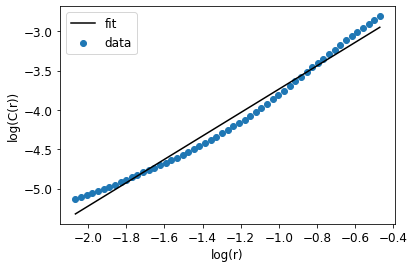

 85%|████████▌ | 341/400 [3:27:15<30:47, 31.31s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4844289383160416
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


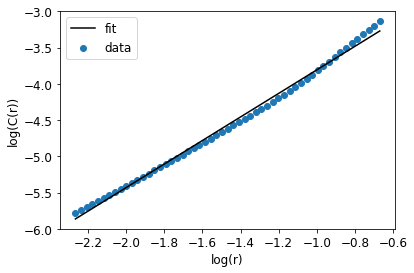

 86%|████████▌ | 342/400 [3:27:22<23:04, 23.87s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6252866415732317
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


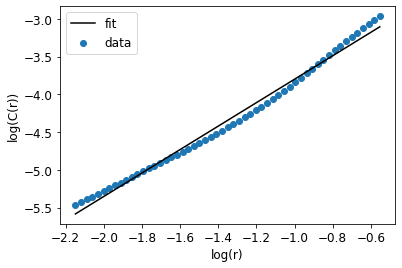

 86%|████████▌ | 343/400 [3:27:24<16:27, 17.33s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.553318586060555
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


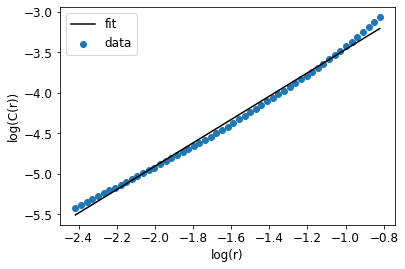

 86%|████████▌ | 344/400 [3:27:25<11:40, 12.52s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4424971746683486
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


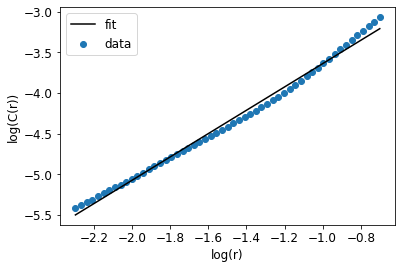

 86%|████████▋ | 345/400 [3:27:27<08:41,  9.49s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4352339649589514
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


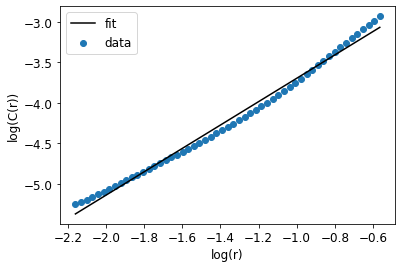

 86%|████████▋ | 346/400 [3:27:30<06:36,  7.34s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4444839644215577
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


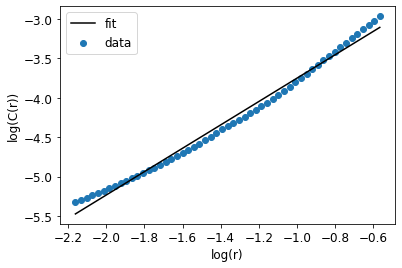

 87%|████████▋ | 347/400 [3:27:31<04:47,  5.43s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4802410541196764
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


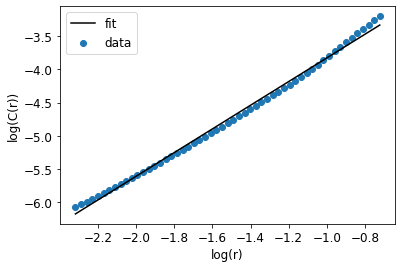

 87%|████████▋ | 348/400 [3:28:15<14:49, 17.12s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7808876871555257
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


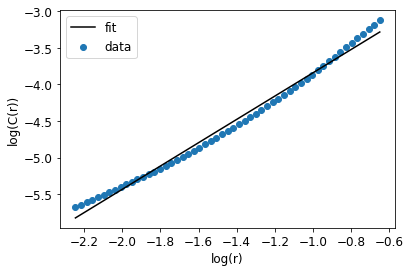

 87%|████████▋ | 349/400 [3:28:18<10:58, 12.91s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5939543608333009
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.36
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00702
Activity number: 147.64903
**************************************************


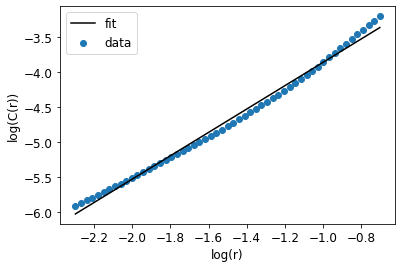

 88%|████████▊ | 350/400 [3:28:27<09:40, 11.60s/it]

0    2.74359
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6719189395672491
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


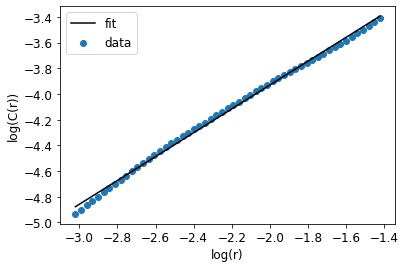

 88%|████████▊ | 351/400 [3:29:11<17:21, 21.26s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.9297205063772154
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


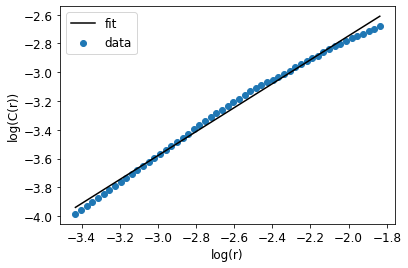

 88%|████████▊ | 352/400 [3:29:55<22:32, 28.17s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8323709111069701
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


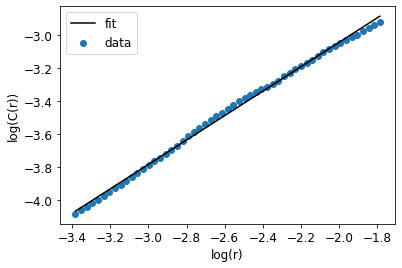

 88%|████████▊ | 353/400 [3:30:40<25:56, 33.11s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.740631399083973
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


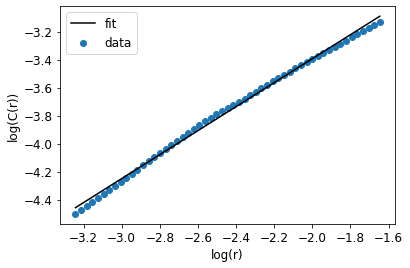

 88%|████████▊ | 354/400 [3:31:24<27:57, 36.47s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8574976788331813
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


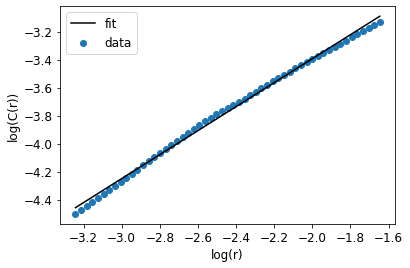

 89%|████████▉ | 355/400 [3:32:09<29:11, 38.93s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8574976788331813
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


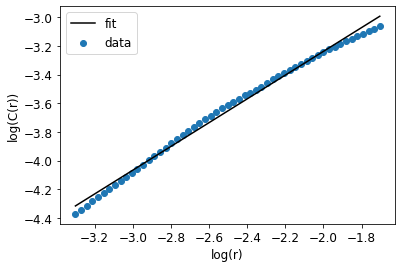

 89%|████████▉ | 356/400 [3:32:53<29:45, 40.58s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8292486553346937
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


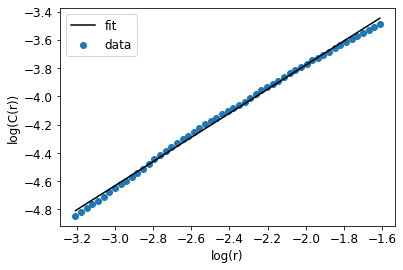

 89%|████████▉ | 357/400 [3:33:37<29:49, 41.60s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8530343975875903
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


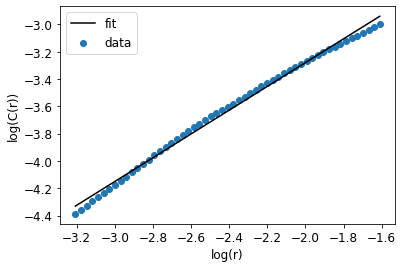

 90%|████████▉ | 358/400 [3:34:21<29:44, 42.49s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8711836287528448
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


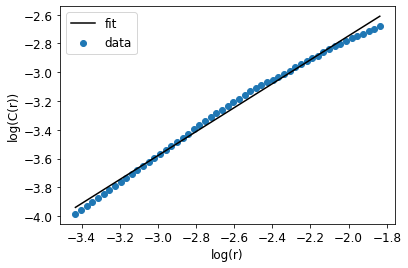

 90%|████████▉ | 359/400 [3:35:05<29:20, 42.93s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8323709111069701
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.33
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00768
Activity number: 161.448
**************************************************


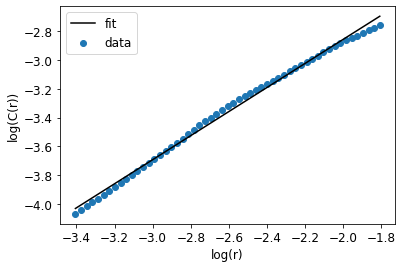

 90%|█████████ | 360/400 [3:35:49<28:47, 43.18s/it]

0    3.0
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.8357983195662784
Filament behavior:  2n-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


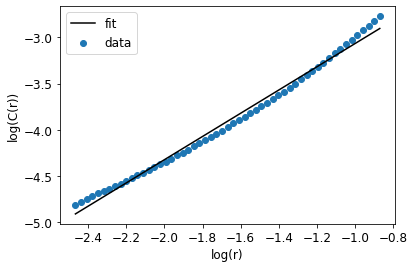

 90%|█████████ | 361/400 [3:35:50<19:42, 30.33s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2555299251061753
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


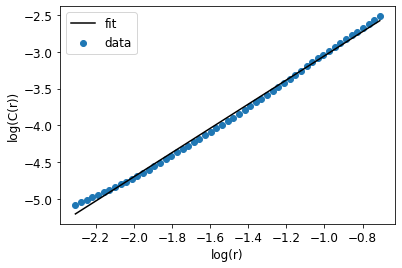

 90%|█████████ | 362/400 [3:35:51<13:37, 21.51s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.640603847374549
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


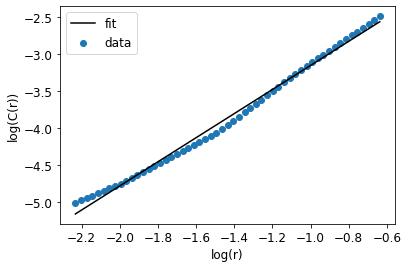

 91%|█████████ | 363/400 [3:35:51<09:21, 15.19s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6305774250867051
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


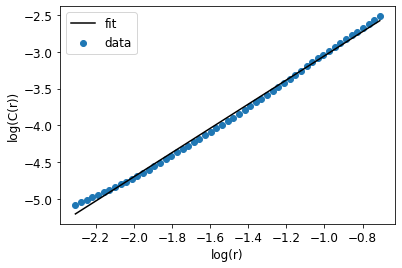

 91%|█████████ | 364/400 [3:35:52<06:32, 10.91s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.640603847374549
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


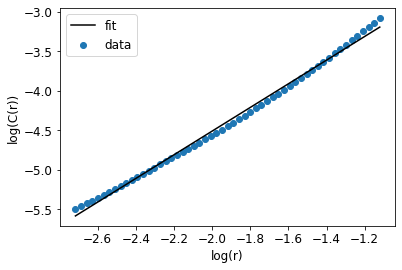

 91%|█████████▏| 365/400 [3:35:56<05:11,  8.91s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.4973064156947862
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


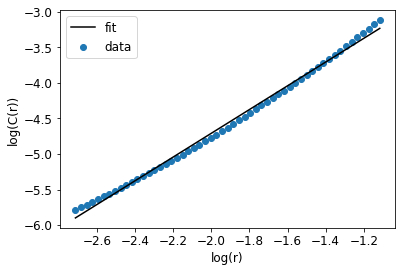

 92%|█████████▏| 366/400 [3:35:58<03:52,  6.84s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6702515852649307
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


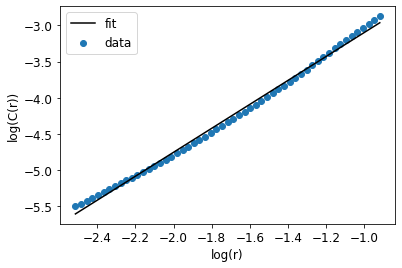

 92%|█████████▏| 367/400 [3:36:00<02:53,  5.27s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.6551889467454899
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


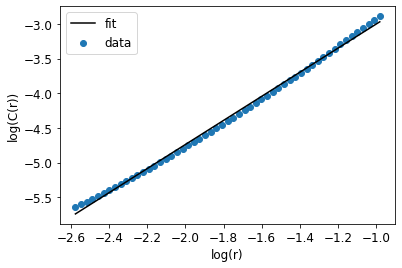

 92%|█████████▏| 368/400 [3:36:02<02:21,  4.42s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.7373807849475624
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


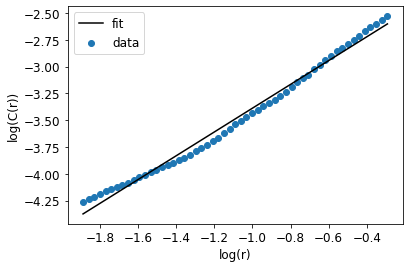

 92%|█████████▏| 369/400 [3:36:02<01:38,  3.17s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.1106039409661452
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.46
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00555
Activity number: 116.60133
**************************************************


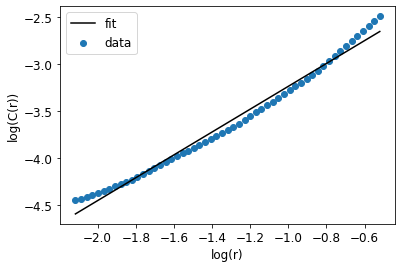

 92%|█████████▎| 370/400 [3:36:03<01:09,  2.31s/it]

0    2.166667
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.2181294798407951
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


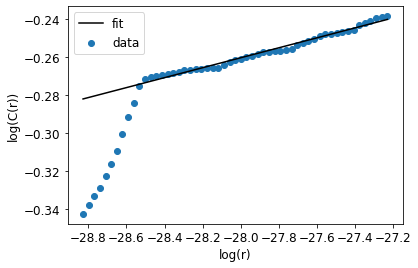

 93%|█████████▎| 371/400 [3:36:46<07:06, 14.69s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.026267769938660646
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


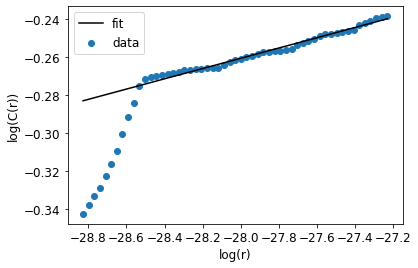

 93%|█████████▎| 372/400 [3:37:30<10:56, 23.44s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.027100910034632462
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


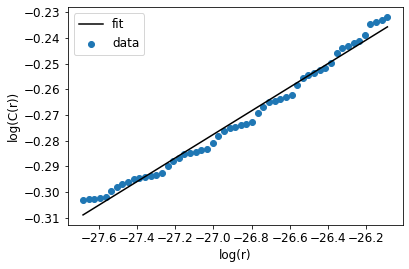

 93%|█████████▎| 373/400 [3:38:14<13:16, 29.51s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.04581621190329489
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


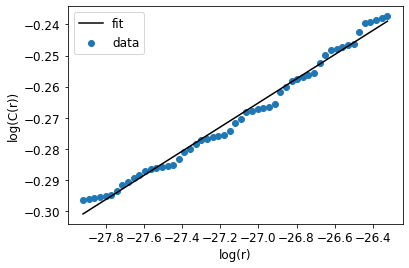

 94%|█████████▎| 374/400 [3:38:57<14:37, 33.75s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.038823127547158304
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


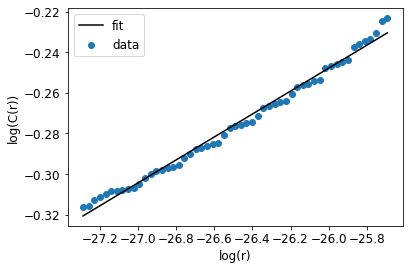

 94%|█████████▍| 375/400 [3:39:41<15:17, 36.70s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.05652440674691761
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


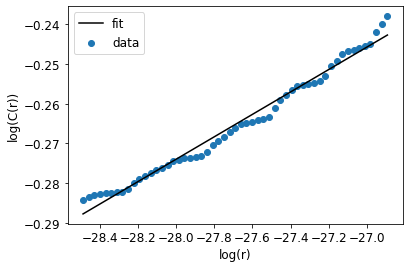

 94%|█████████▍| 376/400 [3:40:25<15:31, 38.83s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.028240865946412525
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


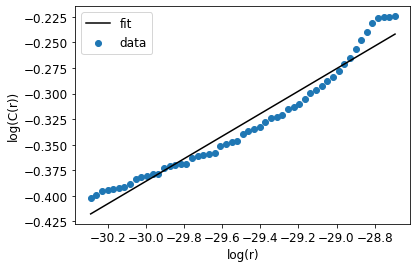

 94%|█████████▍| 377/400 [3:41:09<15:27, 40.31s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.1102075738190683
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


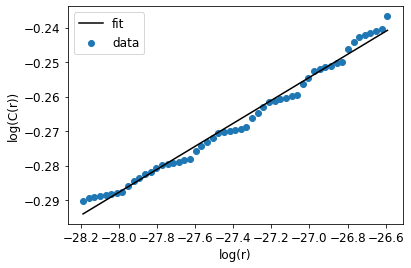

 94%|█████████▍| 378/400 [3:41:52<15:08, 41.32s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.03333930682367526
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


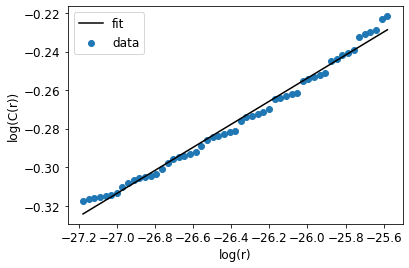

 95%|█████████▍| 379/400 [3:42:36<14:42, 42.01s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.0598709818870618
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 1.59
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00161
Activity number: 33.80749
**************************************************


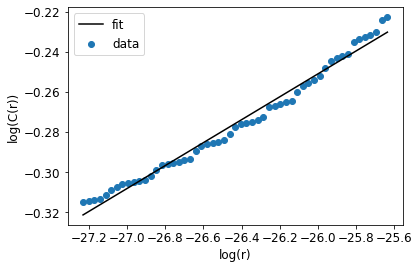

 95%|█████████▌| 380/400 [3:43:20<14:11, 42.58s/it]

0    0.628205
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.057136749364811015
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


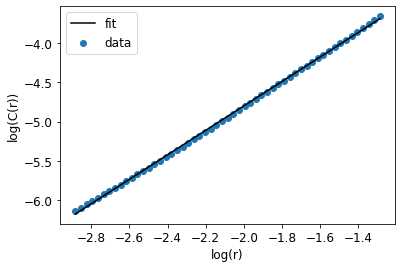

 95%|█████████▌| 381/400 [3:44:03<13:35, 42.91s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5508807478341466
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


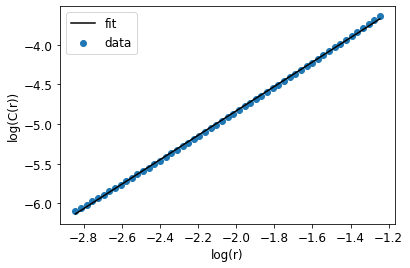

 96%|█████████▌| 382/400 [3:44:47<12:55, 43.08s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.541317089174743
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


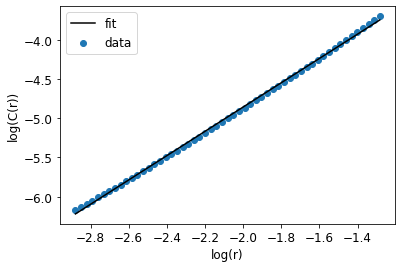

 96%|█████████▌| 383/400 [3:45:31<12:17, 43.38s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5490682072108408
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


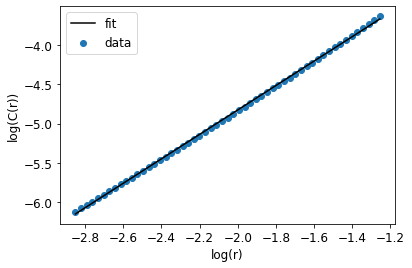

 96%|█████████▌| 384/400 [3:46:15<11:35, 43.46s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5583513328941059
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


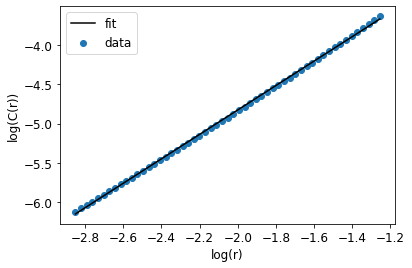

 96%|█████████▋| 385/400 [3:46:59<10:54, 43.64s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5583513328941059
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


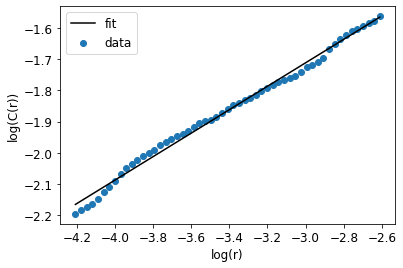

 96%|█████████▋| 386/400 [3:47:42<10:10, 43.64s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.37682942559499943
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


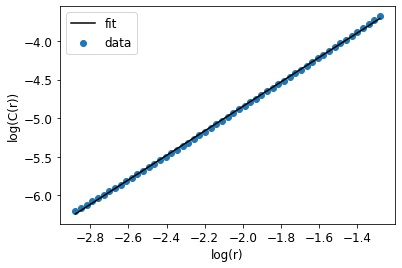

 97%|█████████▋| 387/400 [3:48:26<09:27, 43.64s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.586397391309626
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


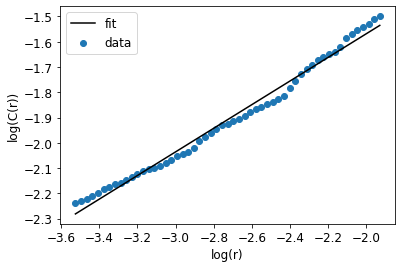

 97%|█████████▋| 388/400 [3:49:10<08:44, 43.67s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.46742155667849006
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


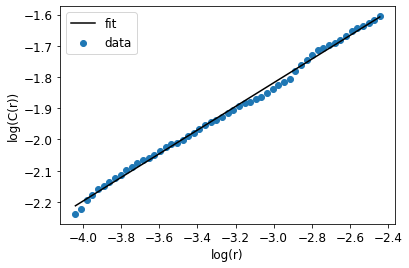

 97%|█████████▋| 389/400 [3:49:54<08:01, 43.75s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.3789720865523484
Filament behavior:  1-period
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.38
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.0067
Activity number: 140.74954
**************************************************


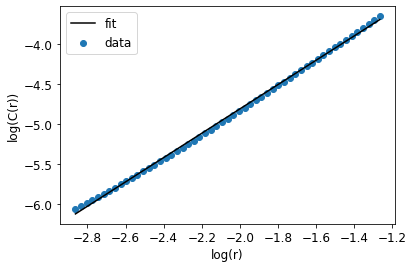

 98%|█████████▊| 390/400 [3:50:38<07:18, 43.89s/it]

0    2.615385
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.5178037221047986
Filament behavior:  aperiodic
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


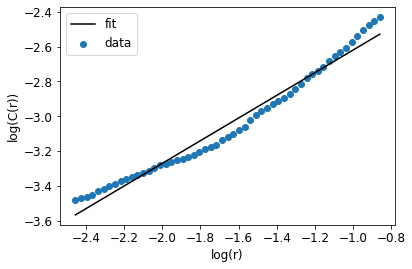

 98%|█████████▊| 391/400 [3:50:38<04:37, 30.78s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.6506917543485747
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


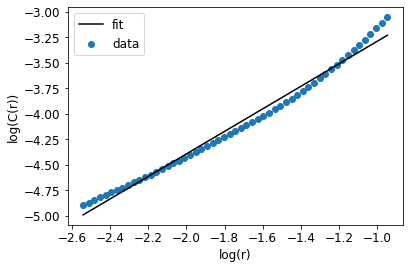

 98%|█████████▊| 392/400 [3:50:39<02:53, 21.71s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.103718261727586
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


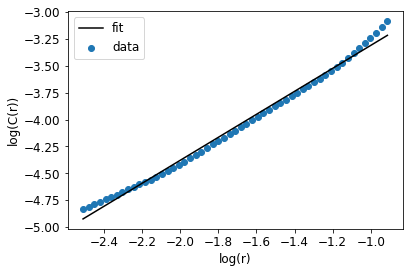

 98%|█████████▊| 393/400 [3:50:39<01:47, 15.30s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.069430438026431
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


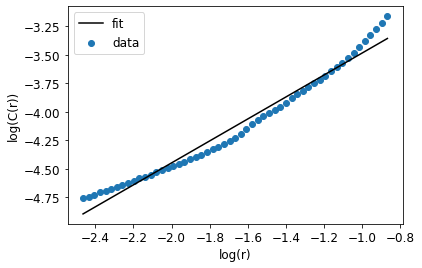

 98%|█████████▊| 394/400 [3:50:39<01:05, 10.85s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.96368419746124
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


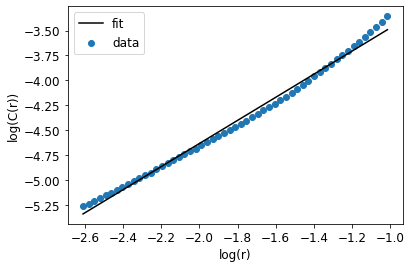

 99%|█████████▉| 395/400 [3:50:40<00:39,  7.85s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.157630494711562
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


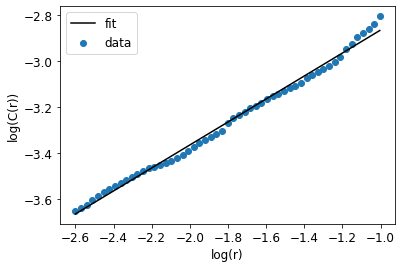

 99%|█████████▉| 396/400 [3:50:41<00:22,  5.55s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4996793245200838
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


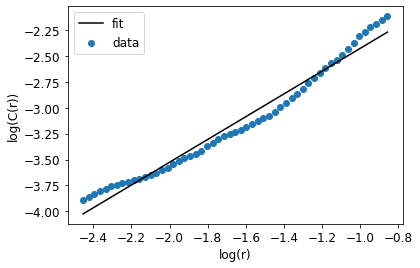

 99%|█████████▉| 397/400 [3:50:41<00:11,  3.97s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  1.0988668681129683
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


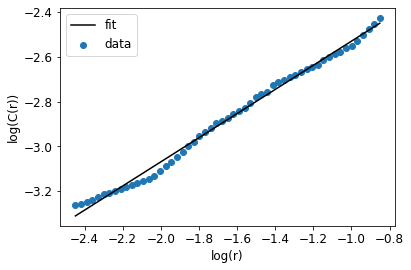

100%|█████████▉| 398/400 [3:50:41<00:05,  2.83s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.5391521385430339
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


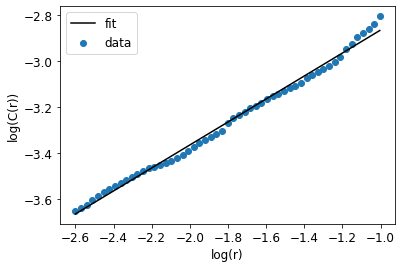

100%|█████████▉| 399/400 [3:50:41<00:02,  2.04s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4996793245200838
Filament behavior:  escape
Attribute not found
**************************************************
Time-scales
**************************************************
Stretch relzation time: 0.43
Bend relaxation time: 228072.75
Active motility time-scale: 0.35
1
**************************************************
Dimensionless numbers
**************************************************
Force per unit lenth due to activity: 0.00735
Activity number: 154.54851
**************************************************


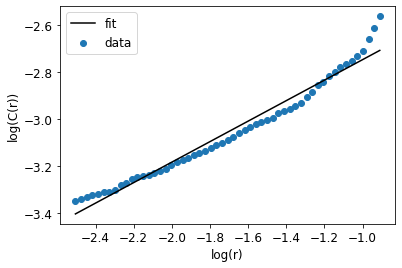

100%|██████████| 400/400 [3:50:41<00:00, 34.60s/it]

0    2.871795
Name: potDipole strength, dtype: float64
estimated attractor dimension:  0.4356610431186867
Filament behavior:  escape


In [4]:
for file in tqdm(full_path_list):
  
    estimate_attractor_dimension_timeseries(file)
    
 
        
        
        
        
    
    

